In [ ]:
#jupyter nbconvert --to script full_notebook.ipynb
#! Ver cómo cambiar el hyperband para que busque más configuraciones si saturan. O para que descarte las que saturan a una sola clase.
#! Comparar con lo que encuentra Random Search y Grid search.
#! El number of estimators del random forest, hacer una especie de early stopping hasta el máximo en el que se hizo el hpo

In [7]:
# # Remove any existing log files
# import os
# import glob
# import logging

# # Reset logger to avoid any issues with permissions
# logging.shutdown()
# # Remove loggers
# for log_file in glob.glob("*.log"):
#     os.remove(log_file)



# 0. Setup and Configuration

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For confusion matrix heatmap
from scipy.stats import randint, uniform, loguniform # Ensure loguniform is imported if used
import os
import json
import time
from datetime import datetime
import math
import logging
from tqdm import tqdm  
from IPython.display import display
#from tqdm.notebook import tqdm # Needs pip install ipywidgets
#from tqdm.auto import tqdm
import joblib # For saving/loading models efficiently

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterSampler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import loguniform # For hyperparameter distributions
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score,
    brier_score_loss, precision_recall_curve, auc, f1_score
)   
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.exceptions import NotFittedError

# Boosting models
import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgb
from lightgbm import early_stopping

# Configure logging
logging.shutdown()
logging.basicConfig(
    filename=f'models_{datetime.now().strftime("%d_%H-%M-%S")}.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)
# Prevent logs from being printed to console
logging.getLogger().handlers = [h for h in logging.getLogger().handlers if isinstance(h, logging.FileHandler)]

## 1. Loading Dataset & Feature Selection

- Group 1: Morphology (magnitudes with errors).
- Group 2: Photometry (magnitudes with errors).
- Group 3: Combined morphology and photometry.

In [9]:
# Read the df
df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
logging.info(f"DataFrame created with shape: {df.shape}")
# Map ACS classification: 1 (Galaxy, Majority) -> 0, 2 (Star, minority) -> 1, 3 (Fake) -> drop
logging.info("Original class counts:")
logging.info(df['acs_mu_class'].value_counts().to_string())

# Drop fake detections (class 3)
# Drop fake detections
n_fakes = (df['acs_mu_class'] == 3).sum()
logging.info(f"Number of fake detections (class 3): {n_fakes}")
df = df[df['acs_mu_class'] != 3]

# Map classifications
df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})

logging.info("After dropping fakes and mapping classes (0: Galaxy, 1: Star):")
logging.info(df['acs_mu_class'].value_counts().to_string())

In [10]:
# Input features

# --- Modeling features ---

# 1. ALHAMBRA Morphology Features (SExtractor-based)
morphology_features = [
    'area', 'fwhm', 'stell', 
    'ell', #'a', 'b', #'theta', #a,b son fwhm y ell. Theta no da info.
    'rk', 
    'rf'
]

morphology_err = [
    's2n'
]

morphology_mags_errors = morphology_features + morphology_err

# 2. ALHAMBRA Photometry (Optical + NIR + Synthetic)
OPTICAL_MAG_COLS = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W',
    'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W',
    'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W'
]
photometry_magnitudes = (
    OPTICAL_MAG_COLS +
    ['J', 'H', 'KS', 'F814W']
)

OPTICAL_ERR_COLS = [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W',
    'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W',
    'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W'
]
photometry_uncertainties = (
    OPTICAL_ERR_COLS +
    ['dJ', 'dH', 'dKS', 'dF814W']
)

photometry_mags_errors = photometry_magnitudes + photometry_uncertainties

# Target from acs
target_variable = ['acs_mu_class'] # The COSMOS classification label to predict

# --- Non-Modeling features ---

# ALHAMBRA Photometric Redshift & Derived Features (BPZ-based)
redshift_magnitudes = [
    'zb_1', 'zb_Min_1', 'zb_Max_1', 'Tb_1',
    'z_ml', 't_ml',
    'Stell_Mass_1', 'M_Abs_1', 'MagPrior'
]

redshift_uncertainties = [
    'Odds_1', 'Chi2'
]

redshift_mags_errors = redshift_magnitudes + redshift_uncertainties

# ALHAMBRA Quality/Auxiliary Features (per-band quality etc.)
OPTICAL_IRMS_COLS = [
    'irms_F365W', 'irms_F396W', 'irms_F427W', 'irms_F458W', 'irms_F489W',
    'irms_F520W', 'irms_F551W', 'irms_F582W', 'irms_F613W', 'irms_F644W',
    'irms_F675W', 'irms_F706W', 'irms_F737W', 'irms_F768W', 'irms_F799W',
    'irms_F830W', 'irms_F861W', 'irms_F892W', 'irms_F923W', 'irms_F954W'
]
quality_aux_features = (
    ['nfobs'] +
    OPTICAL_IRMS_COLS +
    ['irms_J', 'irms_H', 'irms_KS', 'irms_F814W']
)

# Flags and identifiers

non_modeling_identifiers = ['ID_1', 'id_2'] # ALHAMBRA ID, COSMOS ID

non_modeling_astrometry = [
    'RA_1', 'Dec_1', 'x', 'y', # ALHAMBRA Astrometry
    'ra_2', 'dec_2',          # COSMOS Astrometry
    'Separation'              # Matching Quality
]

non_modeling_flags = [
    'photoflag', 'xray', 'PercW', 'Satur_Flag', # ALHAMBRA Object/Photometry Flags
    'irms_OPT_Flag', 'irms_NIR_Flag'           # ALHAMBRA Overall Quality Flags
]

alhambra_prediction = ['Stellar_Flag'] # ALHAMBRA's own classification

non_modeling_aperture_mags = [ # Specific aperture mags, usually use total mags
    'F814W_3arcs', 'dF814W_3arcs', 'F814W_3arcs_corr'
]

non_modeling_cosmos_features = [ # Measurements/flags derived from COSMOS data (HST, HSC, VISTA...)
    'model_flag',
    'flag_hsc', 'flag_supcam', 'flag_udeep', 'flag_uvista',
    'hsc_r_mag', 'hsc_r_magerr', 'hsc_r_valid',
    'hsc_i_mag', 'hsc_i_magerr', 'hsc_i_valid',
    'uvista_j_mag', 'uvista_j_magerr', 'uvista_j_valid',
    'uvista_ks_mag', 'uvista_ks_magerr', 'uvista_ks_valid',
    'acs_f814w_mag', 'acs_f814w_magerr',
    'acs_fwhm_world', 'acs_mu_max',
    'solution_model' # This is categorical, but still COSMOS-derived info
]




# Storing features
feature_sets = {
        # --- Potential Input Feature Sets ---
        'morphology_only': morphology_mags_errors,
        'photometry_magnitudes_only': photometry_magnitudes,
        'photometry_mags_errors': photometry_mags_errors,
        'photometry_plus_morphology': photometry_mags_errors + morphology_mags_errors,
        'photometry_no_redshift': photometry_mags_errors + morphology_mags_errors + quality_aux_features,
        'redshift_only': redshift_mags_errors,
        'full_alhambra_all': (morphology_mags_errors +
                            photometry_mags_errors +
                            redshift_mags_errors + 
                            quality_aux_features),

        # --- Excluded Feature Sets ---
        'non_modeling_identifiers': non_modeling_identifiers,
        'non_modeling_astrometry': non_modeling_astrometry,
        'non_modeling_flags': non_modeling_flags,
        'non_modeling_aperture_mags': non_modeling_aperture_mags,
        'non_modeling_cosmos_features': non_modeling_cosmos_features,
        'alhambra_prediction': alhambra_prediction,
        'target_variable': target_variable
    }

# Groups of features for modeling
groups = {
        'group_1': feature_sets.get('morphology_only', []) + feature_sets.get('target_variable', []),
        'group_2': feature_sets.get('photometry_mags_errors', []) + feature_sets.get('target_variable', []),
        'group_3': (feature_sets.get('morphology_only', []) +
                   feature_sets.get('photometry_mags_errors', []) +
                   feature_sets.get('target_variable', []))
    }

# --- Function to get a specific feature set ---

def get_feature_set(df, set_name, groups = groups):
    """
    Selects columns from a DataFrame based on a predefined feature set name,
    including six specific groups defined by combinations of morphology,
    photometry magnitudes, uncertainties, and redshift features.

    Args:
        df (pd.DataFrame): The input DataFrame.
        set_name (str): The name of the desired feature set group:
                        'group_1' to 'group_6' as defined below.

    Returns:
        pd.DataFrame: A DataFrame containing only the columns
                      belonging to the specified feature set group.
                      Returns an empty DataFrame if no columns are found.
    """

    if set_name not in groups:
        raise ValueError(f"Feature set group '{set_name}' not defined. "
                         f"Available groups: {list(groups.keys())}")

    required_cols_in_set = groups[set_name]

    # Find which of these columns actually exist in the DataFrame
    available_cols = [col for col in required_cols_in_set if col in df.columns]

    # Warn if some columns from the set definition are missing
    missing_cols = [col for col in required_cols_in_set if col not in available_cols]
    if missing_cols:
        print(f"Warning: The following columns defined for feature set group '{set_name}'"
              f" were not found in the DataFrame and will be excluded: {missing_cols}")

    if not available_cols:
        print(f"Warning: No columns for feature set group '{set_name}' found in the DataFrame.")
        return pd.DataFrame()  # Return empty DataFrame

    print(f"Selecting feature set group '{set_name}' with {len(available_cols)} columns.")
    return df[available_cols]


## 2. Data Preprocessing and Splitting

In [11]:
# Data splitting parameters
TEST_SIZE = 0.20 # Test set proportion
VAL_SIZE = 0.10 # Validation set proportion
CAL_SIZE = 0.00 # Calibration set proportion
# Train size will be 1 - (TEST_SIZE + VAL_SIZE + CAL_SIZE)

TARGET_COLUMN = feature_sets.get('target_variable', [])[0]
RANDOM_SEED = 33 # For reproducibility

# Model saving directory
MODEL_DIR = "trained_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Data splitting strategy ('stratified' or 'random')
SPLIT_STRATEGY = 'stratified' # Recommended for imbalanced datasets


In [12]:
# --- Data Cleaning ---
def clean_data(df, feature_group, target_column, logger=logging):
    """
    Cleans the input DataFrame by selecting features for the given group,
    dropping NaNs, and separating features and target.

    Args:
        df (pd.DataFrame): The input DataFrame.
        feature_group (str): The feature group to use (e.g., 'group_1', 'group_2', etc.).
        target_column (str): The name of the target column.
        logger (logging.Logger): Logger for info and error messages.

    Returns:
        X (pd.DataFrame): Cleaned feature DataFrame.
        y (pd.Series): Target variable.
        df_clean (pd.DataFrame): The cleaned DataFrame (features + target).
    """
    logger.info(f"Original dataset size: {df.shape}")

    # Get the feature columns for the selected group using get_feature_set
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    logger.info(f"Dataset size after dropping NaNs: {df_clean.shape}")

    # Ensure target_column is defined correctly
    if target_column not in df_clean.columns:
        raise KeyError(f"Target column '{target_column}' not found in the cleaned DataFrame columns: {df_clean.columns.tolist()}")

    # Log value counts for target
    logger.info(f"Value counts for target:\n1 (Star): {(df_clean[target_column] == 1).sum()}\n0 (Galaxy): {(df_clean[target_column] == 0).sum()}")

    # Separate features (X) and target (y) for the cleaned DataFrame
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y, df_clean

# Example usage:
# X, y, df_clean = clean_data(df, feature_group='group_7', target_column=TARGET_COLUMN, logger=logging)

In [13]:
# --- Data Splitting ---
def split_data(X, y):
    """
    Splits the data into train, validation, test, and calibration sets according to the global
    split proportions and strategy. Uses global variables:
        - TEST_SIZE, VAL_SIZE, CAL_SIZE, SPLIT_STRATEGY, RANDOM_SEED

    The logic and split order is identical to the original code.

    Args:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target variable.

    Returns:
        (X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal): tuple of splits.
    """
    logging.info(f"Splitting data using '{SPLIT_STRATEGY}' strategy...")

    # --- Validate Proportions ---
    if not (0 <= TEST_SIZE <= 1 and 0 <= VAL_SIZE <= 1 and 0 <= CAL_SIZE <= 1):
        raise ValueError("Split proportions (TEST_SIZE, VAL_SIZE, CAL_SIZE) must be between 0 and 1.")

    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE
    if not (0 <= TRAIN_SIZE <= 1):
        raise ValueError(f"Calculated TRAIN_SIZE ({TRAIN_SIZE:.3f}) is invalid. Sum of TEST_SIZE, VAL_SIZE, and CAL_SIZE must be between 0 and 1.")

    if not np.isclose(TRAIN_SIZE + TEST_SIZE + VAL_SIZE + CAL_SIZE, 1.0):
        # This check might be redundant given the calculation of TRAIN_SIZE, but good for safety.
        raise ValueError("Sum of split proportions must be equal to 1.")

    if np.isclose(TRAIN_SIZE, 0) and (np.isclose(VAL_SIZE, 0) or np.isclose(TEST_SIZE, 0) or np.isclose(CAL_SIZE, 0)):
        # Avoid scenarios where train is 0 but other splits are also 0, leading to ambiguity.
        # If only train is 0, it might be valid in some rare cases, but usually requires at least one other non-zero split.
        # Let's enforce Train > 0 for typical ML workflows.
        # If you need zero training data, adjust this check.
        logging.warning("TRAIN_SIZE is zero or near zero. Ensure this is intended.")
        if TRAIN_SIZE < 0: # Definitely an error
            raise ValueError("TRAIN_SIZE cannot be negative.")
        # Allow TRAIN_SIZE = 0 only if explicitly handled later, otherwise raise error?
        # For now, let's proceed but log a warning. If TRAIN_SIZE must be > 0, uncomment the raise below.
        # raise ValueError("TRAIN_SIZE must be greater than 0 for typical model training.")

    logging.info(f"Target split ratios: Train={TRAIN_SIZE:.2f}, Val={VAL_SIZE:.2f}, Test={TEST_SIZE:.2f}, Cal={CAL_SIZE:.2f}")

    # --- Initialize Splits ---
    # Use iloc[0:0] to create empty DataFrames/Series with the same columns/dtype
    empty_X = X.iloc[0:0]
    empty_y = y.iloc[0:0]
    X_train, y_train = empty_X.copy(), empty_y.copy()
    X_val, y_val = empty_X.copy(), empty_y.copy()
    X_test, y_test = empty_X.copy(), empty_y.copy()
    X_cal, y_cal = empty_X.copy(), empty_y.copy()

    # Temporary variables for sequential splitting
    X_remaining, y_remaining = X.copy(), y.copy() # Use copies to avoid modifying original X, y

    # --- Stratification Option ---
    # Define stratify_func only once
    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    # --- First Split: Train vs. Remainder (Val + Test + Cal) ---
    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE

    if np.isclose(val_test_cal_size, 0): # Only Train set needed
        X_train, y_train = X_remaining, y_remaining
        logging.info("All data assigned to Train set (Val, Test, Cal sizes are 0).")
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy() # No remainder
    elif np.isclose(TRAIN_SIZE, 0): # No Train set needed
        logging.info("Train set is empty (TRAIN_SIZE=0). Remainder passed to next splits.")
        # X_remaining, y_remaining already hold all data
    else: # Split Train vs Remainder
        split_test_size = val_test_cal_size # Proportion of remainder relative to total (1.0)
        X_train, X_remaining, y_train, y_remaining = train_test_split(
            X_remaining, y_remaining,
            test_size=split_test_size,
            random_state=RANDOM_SEED,
            stratify=get_stratify_array(y_remaining)
        )
    logging.info(f"Train set shape: {X_train.shape}")

    # --- Second Split: Val vs. Remainder (Test + Cal) ---
    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        # Denominator for relative size calculation: size of the current remaining pool
        current_remaining_size_frac = VAL_SIZE + test_cal_size # = val_test_cal_size

        if np.isclose(VAL_SIZE, 0): # No Val set, pass remainder to next stage
            X_temp2, y_temp2 = X_remaining, y_remaining # Remainder is Test + Cal
            logging.info("Validation set is empty (VAL_SIZE=0).")
        elif np.isclose(test_cal_size, 0): # Only Val set left in remainder
            X_val, y_val = X_remaining, y_remaining
            X_temp2, y_temp2 = empty_X.copy(), empty_y.copy() # No data left for Test/Cal
            logging.info(f"Validation set shape: {X_val.shape}")
        else: # Split Val vs (Test + Cal)
            # Proportion of (Test + Cal) relative to (Val + Test + Cal)
            split_test_size = test_cal_size / current_remaining_size_frac
            X_val, X_temp2, y_val, y_temp2 = train_test_split(
                X_remaining, y_remaining,
                test_size=split_test_size,
                random_state=RANDOM_SEED,
                stratify=get_stratify_array(y_remaining)
            )
            logging.info(f"Validation set shape: {X_val.shape}")
    else: # No data remaining after train split
        X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
        if not np.isclose(VAL_SIZE, 0): # Log only if Val set was expected
            logging.info("Validation set is empty (no data remaining after train split).")

    # --- Third Split: Test vs. Cal ---
    if not X_temp2.empty:
        # Denominator for relative size calculation: size of the current remaining pool
        current_remaining_size_frac = TEST_SIZE + CAL_SIZE # = test_cal_size

        if np.isclose(CAL_SIZE, 0): # No Cal set, remainder is Test
            X_test, y_test = X_temp2, y_temp2
            logging.info("Calibration set is empty (CAL_SIZE=0).")
        elif np.isclose(TEST_SIZE, 0): # Only Cal set left in remainder
            X_cal, y_cal = X_temp2, y_temp2
            logging.info("Test set is empty (TEST_SIZE=0).")
        else: # Split Test vs Cal
            # Proportion of Cal relative to (Test + Cal)
            split_test_size = CAL_SIZE / current_remaining_size_frac
            X_test, X_cal, y_test, y_cal = train_test_split(
                X_temp2, y_temp2,
                test_size=split_test_size,
                random_state=RANDOM_SEED,
                stratify=get_stratify_array(y_temp2)
            )
            # Logging shapes done after the if/else block
    else: # No data remaining for Test/Cal split
        if not (np.isclose(TEST_SIZE, 0) and np.isclose(CAL_SIZE, 0)): # Log only if Test or Cal were expected
            logging.info("Test and Calibration sets are empty (no data remaining for final split).")

    # Log final shapes for Test and Cal
    logging.info(f"Test set shape: {X_test.shape}")
    logging.info(f"Calibration set shape: {X_cal.shape}")

    # --- Verification and Final Logging ---
    total_len = len(X_train) + len(X_val) + len(X_test) + len(X_cal)
    original_len = len(X)

    if total_len != original_len:
        # Calculate actual proportions based on lengths
        actual_train = len(X_train) / original_len if original_len > 0 else 0
        actual_val = len(X_val) / original_len if original_len > 0 else 0
        actual_test = len(X_test) / original_len if original_len > 0 else 0
        actual_cal = len(X_cal) / original_len if original_len > 0 else 0
        logging.warning(f"Total split length ({total_len}) does not exactly match original length ({original_len}). "
                        f"This can happen with stratification or rounding. "
                        f"Target proportions: Train={TRAIN_SIZE:.3f}, Val={VAL_SIZE:.3f}, Test={TEST_SIZE:.3f}, Cal={CAL_SIZE:.3f}. "
                        f"Actual proportions: Train={actual_train:.3f}, Val={actual_val:.3f}, Test={actual_test:.3f}, Cal={actual_cal:.3f}")
    else:
        logging.info("Split lengths verification successful.")

    logging.info("Data splitting complete.")

    # Log distributions, handling empty sets
    def log_distribution(name, y_set):
        if y_set.empty:
            logging.info(f"{name} target distribution: Set is empty.")
        else:
            try:
                # Use normalize=True, handle potential division by zero if counts are zero (though unlikely if not empty)
                counts = y_set.value_counts()
                dist = counts / counts.sum() if counts.sum() > 0 else counts
                logging.info(f"{name} target distribution:\n{dist}")
                # Log absolute counts as well for clarity
                logging.info(f"{name} target counts:\n{counts}")
            except Exception as e:
                logging.error(f"Could not calculate distribution for {name}: {e}")
                # Attempt to log raw value counts even if normalization fails
                try:
                    logging.info(f"{name} raw value counts:\n{y_set.value_counts()}")
                except Exception as e_raw:
                    logging.error(f"Could not get raw value counts for {name}: {e_raw}")

    log_distribution("Train", y_train)
    log_distribution("Validation", y_val)
    log_distribution("Test", y_test)
    log_distribution("Calibration", y_cal)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal

# 3. Implementation

### Hyperparameter Optimization via Hyperband

In [14]:
# --- Internal Helper ---
def _train_and_eval(model_class, params,
                    X_train, y_train, X_val, y_val,
                    resource, resource_type,
                    scoring_func, random_state):
    """Internal helper function to train and evaluate a single configuration."""
    try:
        # Instantiate the base model without iteration-specific params first
        # Iteration param (e.g., n_estimators) will be handled later if needed
        model = model_class(**params)

        fit_duration = 0.0
        eval_duration = 0.0
        start_fit = time.time() # Start timing fit process

        if resource_type == 'data_fraction':
            # --- FIX 1: Implement data subsetting ---
            if resource < 1.0:
                # Use train_test_split to get a stratified fraction
                # We only need the 'train' part of this split for the subset
                try:
                    X_subset, _, y_subset, _ = train_test_split(
                        X_train, y_train,
                        train_size=resource,
                        random_state=random_state, # Use provided random state
                        stratify=y_train # Stratify based on original train labels
                    )
                except ValueError as e:
                    # Handle cases where stratification is not possible (e.g., too few samples)
                    logging.warning(f"Stratification failed for resource {resource:.2f}: {e}. Falling back to non-stratified split.")
                    X_subset, _, y_subset, _ = train_test_split(
                        X_train, y_train,
                        train_size=resource,
                        random_state=random_state
                    )
            else:
                # Use the full training data if resource is 1.0
                X_subset, y_subset = X_train, y_train

            # Ensure y_subset is numpy for fitting if needed by model
            y_subset_np = y_subset.values if isinstance(y_subset, pd.Series) else y_subset

            # Fit the model 
            model.fit(X_subset, y_subset_np)
            fit_duration = time.time() - start_fit
            # -----------------------------------------

        elif resource_type == 'iterations':
            # Resource represents n_estimators or similar iteration parameter
            params_iter = params.copy() # Avoid modifying original params dict
            iter_param_name = 'n_estimators' # Common case for RF, XGB, LGBM

            # Ensure resource is an integer for iterations
            params_iter[iter_param_name] = int(max(1, resource)) # Ensure at least 1 iteration
            model = model_class(**params_iter) # Re-instantiate with correct n_estimators

            # --- FIX 2 & 3: Conditional Fit Parameters ---
            current_fit_args = {} # Dictionary for specific fit arguments
            eval_set_for_fit = [(X_val, y_val)] # Common eval set

            if model_class is xgb.XGBClassifier:
                current_fit_args['eval_set'] = eval_set_for_fit
                current_fit_args['verbose'] = False

            elif model_class is lgb.LGBMClassifier:
                current_fit_args['eval_set'] = eval_set_for_fit
                if 'metric' in params_iter: # Get metric from HPO params
                     current_fit_args['eval_metric'] = params_iter['metric']
                elif isinstance(model.metric, str): # Get metric from model instance if set
                     current_fit_args['eval_metric'] = model.metric
                else: # Default if not found (might cause issues if early stopping expects it)
                     logging.warning(f"LGBM eval_metric not found in HPO params or model instance for config {params_iter}. Early stopping might fail.")
                     # You might need to add a default like 'logloss' or raise an error
                     # current_fit_args['eval_metric'] = 'logloss' # Example default

            # For models like RandomForest or DecisionTree, current_fit_args remains empty {}
            # as they don't use eval_set or callbacks in their standard fit method

            # Fit the model with appropriate arguments
            # Ensure y_train is numpy if needed
            y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
            try:
                model.fit(X_train, y_train_np, **current_fit_args)
            except Exception as fit_error:
                 logging.error(f"Fit failed for config {params_iter} with resource {resource}: {fit_error}")
                 # logging.exception("Fit Traceback:") # Uncomment for full traceback
                 return -1.0 # Indicate failure
            fit_duration = time.time() - start_fit
            # -----------------------------------------

        else:
            raise ValueError("Invalid resource_type. Choose 'data_fraction' or 'iterations'.")

        # Evaluate on the full validation set (common part)
        start_eval = time.time()
        try:
             y_pred_val = model.predict(X_val)
             # Ensure y_val is numpy if needed by scoring_func
             y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val
             score = scoring_func(y_val_np, y_pred_val)
        except Exception as eval_error:
             logging.error(f"Predict/Score failed for config {params} with resource {resource}: {eval_error}")
             score = -1.0 # Indicate failure
        eval_duration = time.time() - start_eval

        logging.debug(f"Evaluated config: {params} | Resource: {resource:.2f} | Score: {score:.4f} | Fit: {fit_duration:.2f}s | Eval: {eval_duration:.2f}s")
        return score

    except Exception as e:
        # Log the configuration that caused the error
        logging.error(f"Error training/evaluating config {params} with resource {resource}: {e}", exc_info=False) # Set exc_info=True for traceback if needed
        return -1.0 # Return a clearly bad score


def hyperband_hpo(model_class, param_space,
                  X_train, y_train, X_val, y_val,
                  max_resource, eta=3, resource_type='iterations',
                  min_resource=1, # Min iterations or min data fraction
                  scoring_func=f1_score, # Function accepting (y_true, y_pred)
                  random_state=None,
                  config_multiplier=3): # For early stopping etc. passed to .fit()
    """
    Performs Hyperband Hyperparameter Optimization.

    Args:
        model_class: The model class (e.g., SVC, RandomForestClassifier).
        param_space (dict): Dictionary defining the hyperparameter search space
                           compatible with ParameterSampler.
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels for evaluation.
        max_resource (float/int): Maximum resource allocation
                                 (e.g., max n_estimators or 1.0 for data fraction).
        eta (int): Reduction factor for successive halving (>= 2).
        resource_type (str): How resource is allocated:
                             'iterations' -> resource sets n_estimators (or similar).
                             'data_fraction' -> resource is fraction of training data used (stratified).
        min_resource (float/int): Minimum resource for the first iteration.
                                 Must be >= 1 for 'iterations', > 0 for 'data_fraction'.
        scoring_func (callable): Function to evaluate performance (e.g., f1_score).
                                Higher score is assumed better.
        random_state (int): Seed for reproducibility of parameter sampling and data subsetting.

    Returns:
        tuple: (best_params, best_score)
               best_params (dict): The hyperparameters of the best performing configuration.
               best_score (float): The score achieved by the best configuration on the validation set
                                  using the maximum resource.
    """

    log_max_r = math.log(max_resource / min_resource, eta) if max_resource > min_resource and min_resource > 0 else 0
    s_max = int(log_max_r)
    B = (s_max + 1) * max_resource # Approximate total resource budget

    logging.info(f"--- Starting Hyperband HPO ---")
    logging.info(f"Model: {model_class.__name__}")
    logging.info(f"Resource Type: {resource_type}")
    logging.info(f"Resource Range: [{min_resource}, {max_resource}]")
    logging.info(f"Eta: {eta}")
    logging.info(f"Max Brackets (s_max): {s_max}")
    logging.info(f"Approx. Budget (B): {B:.2f}")
    logging.info(f"Scoring: {scoring_func.__name__}")

    best_params = None
    best_score = -1.0
    total_configs_evaluated = 0
    outer_tqdm = tqdm(range(s_max, -1, -1), desc="Hyperband Brackets (s)")

    # Outer loop: Iterate through brackets (s values)
    for s in outer_tqdm:
        n_configs = int(math.ceil(int(B / max_resource / (s + 1)) * eta**s)) * config_multiplier # Number of configs in this bracket
        r_initial = max_resource * eta**(-s) # Initial resource for this bracket
        # Ensure initial resource is not less than min_resource
        r_initial = max(r_initial, min_resource)

        outer_tqdm.set_description(f"Bracket s={s} (n={n_configs}, r0={r_initial:.2f})")
        logging.info(f"\n>> Bracket s={s}: n_configs={n_configs}, r_initial={r_initial:.2f}")

        # Sample configurations for this bracket
        param_list = list(ParameterSampler(param_space, n_iter=n_configs, random_state=random_state + s if random_state is not None else None))
        
        # --- Add common fixed parameters ---
        # Calculate scale_pos_weight once if needed
        scale_pos_weight_val = None
        if model_class in [xgb.XGBClassifier, lgb.LGBMClassifier]:
             neg_count = (y_train == 0).sum()
             pos_count = (y_train == 1).sum()
             if pos_count > 0:
                 scale_pos_weight_val = neg_count / pos_count

        for p in param_list:
             # Add random_state if model supports it and it's not sampled
             if 'random_state' not in p and hasattr(model_class(random_state=1), 'random_state'): # Check if attr exists
                 p['random_state'] = random_state
             # Add class_weight='balanced' for relevant sklearn models if not sampled
             if model_class in [SVC, RandomForestClassifier, DecisionTreeClassifier] and 'class_weight' not in p:
                 p['class_weight'] = 'balanced'
             # Add scale_pos_weight for boosting models if not sampled and calculated
             if model_class in [xgb.XGBClassifier, lgb.LGBMClassifier] and 'scale_pos_weight' not in p and scale_pos_weight_val is not None:
                  p['scale_pos_weight'] = scale_pos_weight_val
             # For LightGBM, also consider adding 'objective': 'binary' if not sampled
             if model_class is lgb.LGBMClassifier and 'objective' not in p:
                  p['objective'] = 'binary'
        # -----------------------------------

        # Inner loop: Successive halving rounds
        inner_tqdm = tqdm(range(s + 1), desc=f"SH Round (s={s})", leave=False)
        for i in inner_tqdm:
            current_resource = r_initial * eta**i
            # Ensure resource doesn't exceed max_resource due to floating point/rounding
            current_resource = min(current_resource, max_resource)

            n_configs_in_round = len(param_list)
            inner_tqdm.set_description(f"SH Round i={i} (n={n_configs_in_round}, r={current_resource:.2f})")
            logging.info(f"  -- Round i={i}: Evaluating {n_configs_in_round} configs with resource={current_resource:.2f} --")

            round_scores = []
            # Use tqdm for the configurations within the round
            eval_tqdm = tqdm(param_list, desc=f"Evaluating Configs (i={i})", leave=False)
            for params in eval_tqdm:
                score = _train_and_eval(model_class, params, X_train, y_train, X_val, y_val,
                                        current_resource, resource_type, scoring_func,
                                        random_state)
                round_scores.append((score, params))
                total_configs_evaluated += 1 # Count unique evaluations

            # Sort by score (descending, higher is better)
            round_scores.sort(key=lambda x: x[0], reverse=True)

            # Track the best overall score and params seen so far *at max resource*
            # Only update if we are actually at max resource in this round
            if abs(current_resource - max_resource) < 1e-6: # Check if we are at max resource
                 if round_scores and round_scores[0][0] > best_score:
                      best_score = round_scores[0][0]
                      best_params = round_scores[0][1]
                      logging.info(f"  ** New Best Found (Score: {best_score:.4f}) at max resource ** Params: {best_params}")
                      # Update outer tqdm description with best score found so far
                      outer_tqdm.set_postfix_str(f"Best F1: {best_score:.4f}", refresh=True)


            # --- Halving Step ---
            n_keep = int(n_configs_in_round / eta)
            logging.info(f"  -- Round i={i}: Completed {len(round_scores)} evaluations. Keeping top {n_keep} configs. --")

            if n_keep < 1 or i == s: # Keep at least one, or if it's the last round
                # If it's the last round, ensure the best score from *this bracket* at *max resource* is considered
                if abs(current_resource - max_resource) < 1e-6 and round_scores:
                     bracket_best_score = round_scores[0][0]
                     bracket_best_params = round_scores[0][1]
                     logging.info(f"  Bracket s={s} final best score: {bracket_best_score:.4f}")
                     # No need to update global best here, already done above
                break # Exit inner loop

            # Prepare parameter list for the next round
            param_list = [params for score, params in round_scores[:n_keep]]
            if not param_list: # Safety break if list becomes empty unexpectedly
                 logging.warning(f"  Param list empty after halving round i={i}. Stopping bracket.")
                 break

    logging.info(f"\n--- Hyperband HPO Finished ---")
    logging.info(f"Total configurations evaluated (approx): {total_configs_evaluated}") # Might overcount if errors happened
    if best_params:
        logging.info(f"Best Overall Score ({scoring_func.__name__}): {best_score:.4f}")
        logging.info(f"Best Params: {best_params}")
    else:
        logging.warning("No best parameters found. Check logs for errors or increase resources/configs.")

    return best_params, best_score

### Calibration (Platt Scaling/Isotonic Regression/Cross Venn Abers Predictors)


In [15]:
from raw_cvap import RawVennAbers, CVAPPredictorRaw

# --- Helper Function to Get Scores ---
def get_scores(estimator, X, score_method):
    """Gets scores from an estimator based on the specified method."""
    if score_method == 'decision_function':
        if hasattr(estimator, 'decision_function'):
            scores = estimator.decision_function(X)
            # Ensure scores are 1D for binary classification
            if scores.ndim == 2 and scores.shape[1] == 1:
                 scores = scores.flatten()
            elif scores.ndim > 1:
                 # For binary, decision_function should be 1D. If not, maybe multiclass? Raise error.
                 raise ValueError(f"decision_function returned shape {scores.shape}, expected 1D for binary classification.")
            return scores
        else:
            raise AttributeError(f"{estimator.__class__.__name__} does not have 'decision_function' method.")
    elif score_method == 'predict_proba':
        if hasattr(estimator, 'predict_proba'):
            # Return probability of the positive class (class 1)
            proba = estimator.predict_proba(X)
            if proba.shape[1] != 2:
                 raise ValueError(f"predict_proba returned shape {proba.shape}, expected (n_samples, 2)")
            return proba[:, 1]
        else:
            raise AttributeError(f"{estimator.__class__.__name__} does not have 'predict_proba' method.")
    elif score_method == 'raw_margin_xgb':
        # Check if it looks like an XGBoost model (basic check)
        # A more robust check might involve isinstance(estimator, xgboost.XGBModel) after importing xgboost
        if hasattr(estimator, 'predict') and hasattr(estimator, 'get_params') and 'objective' in estimator.get_params():
             try:
                 # XGBoost convention: predict with output_margin=True gives raw scores
                 # For binary classification, this is usually a single value per instance
                 scores = estimator.predict(X, output_margin=True)
                 return scores.flatten() # Ensure 1D
             except TypeError as e:
                  # Check if the error message specifically mentions 'output_margin'
                  if 'output_margin' in str(e):
                      raise TypeError(f"'output_margin' might not be a valid parameter for predict in this XGBoost version or configuration. Error: {e}")
                  else:
                      raise TypeError(f"Error calling predict with output_margin=True on {estimator.__class__.__name__}. Is it an XGBoost model? Original error: {e}")

        else:
             raise AttributeError(f"{estimator.__class__.__name__} might not be an XGBoost model supporting 'output_margin'.")
    elif score_method == 'raw_score_lgbm':
         # Check if it looks like a LightGBM model (basic check)
         # A more robust check might involve isinstance(estimator, lightgbm.LGBMModel) after importing lightgbm
        if hasattr(estimator, 'predict') and hasattr(estimator, 'get_params') and 'objective' in estimator.get_params():
             try:
                 # LightGBM convention: predict with raw_score=True gives raw scores
                 # For binary classification, output shape might depend on objective.
                 # Often (n_samples,) or (n_samples, 1) for binary logloss/cross_entropy
                 scores = estimator.predict(X, raw_score=True)
                 # Handle potential (n_samples, 1) output for binary
                 if scores.ndim == 2 and scores.shape[1] == 1:
                     scores = scores.flatten()
                 elif scores.ndim != 1:
                      # If multiclass raw_score=True might return (n_samples, n_classes)
                      raise ValueError(f"LightGBM raw_score returned shape {scores.shape}. Expected 1D for binary.")
                 return scores
             except TypeError as e:
                 # Check if the error message specifically mentions 'raw_score'
                 if 'raw_score' in str(e):
                      raise TypeError(f"'raw_score' might not be a valid parameter for predict in this LightGBM version or configuration. Error: {e}")
                 else:
                      raise TypeError(f"Error calling predict with raw_score=True on {estimator.__class__.__name__}. Is it a LightGBM model? Original error: {e}")
        else:
             raise AttributeError(f"{estimator.__class__.__name__} might not be a LightGBM model supporting 'raw_score'.")
    else:
        raise ValueError(f"Unsupported score_method: {score_method}. Choose 'decision_function', 'predict_proba', 'raw_margin_xgb', or 'raw_score_lgbm'.")

# --- Loading and saving models ---
def _get_save_path(model_dir: str, model_name: str, group_name: str, calibration_method: str) -> str:
    """
    Constructs the standardized file path including a group subfolder
    and ensures the target directory exists.

    Args:
        model_dir (str): The base directory for saving models.
        model_name (str): Name of the model (e.g., 'SVM').
        group_name (str): Name of the data group (e.g., 'group_1'). Used for subfolder.
        calibration_method (str): The calibration method ('platt', 'isotonic', 'cvap').

    Returns:
        str: The full, absolute path to the save file.
             Example: /path/to/models/group_1/SVM_group_1_platt.joblib

    Raises:
        OSError: If the directory cannot be created due to permissions or other OS issues.
    """
    # Define the filename (remains the same as before)
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"

    # Define the target directory path including the group subfolder
    # Use group_name as the subfolder name
    target_directory = os.path.join(model_dir, group_name)

    # Ensure the target directory exists; create it if necessary
    try:
        # os.makedirs creates parent directories as needed (like model_dir if it doesn't exist)
        # exist_ok=True prevents an error if the directory already exists
        os.makedirs(target_directory, exist_ok=True)
        logging.debug(f"Ensured directory exists: {target_directory}")
    except OSError as e:
        # Log the error and re-raise it so the calling function knows something went wrong
        logging.error(f"Could not create directory {target_directory}: {e}", exc_info=True)
        raise  # Re-raise the exception to halt execution if directory creation fails

    # Construct the full file path by joining the target directory and filename
    full_file_path = os.path.join(target_directory, filename)

    # Optional: Return absolute path for clarity, especially if model_dir might be relative
    return os.path.abspath(full_file_path)

def save_predictor(predictor_object, file_path: str, model_name: str):
    """Saves the fitted predictor object (CalibratedClassifierCV or CVAPPredictorRaw) to a file."""
    try:
        joblib.dump(predictor_object, file_path)
        logging.info(f"--- [{model_name}] Model with calibrator saved successfully to {file_path} ---")
    except Exception as e:
        logging.error(f"--- [{model_name}] Failed to save model with calibrator to {file_path}: {e} ---", exc_info=True)

def load_predictor(file_path: str, model_name: str):
    """Loads the fitted predictor object from a file."""
    if not os.path.exists(file_path):
        logging.info(f"--- [{model_name}] Predictor save file not found at {file_path}. Proceeding with training. ---")
        return None

    try:
        loaded_predictor = joblib.load(file_path)
        # Basic checks: Is it an object? Does it have predict_proba? Is it fitted?
        if loaded_predictor is not None and hasattr(loaded_predictor, 'predict_proba'):
            # Check if it appears fitted (works for CalibratedClassifierCV, need similar for CVAPPredictorRaw if available)
            try:
                # Check if the base estimator inside CalibratedClassifierCV is fitted
                if isinstance(loaded_predictor, CalibratedClassifierCV):
                     # Access the fitted base estimator(s)
                     estimators_to_check = []
                     if hasattr(loaded_predictor, 'calibrated_classifiers_') and loaded_predictor.calibrated_classifiers_:
                         estimators_to_check = [cc.base_estimator for cc in loaded_predictor.calibrated_classifiers_]
                     elif hasattr(loaded_predictor, 'base_estimator_'): # For older sklearn? Or if fitted directly without CV part?
                          estimators_to_check = [loaded_predictor.base_estimator_]

                     if not estimators_to_check:
                          raise ValueError("Could not find base estimator(s) in loaded CalibratedClassifierCV")

                     # Check if *all* base estimators are fitted
                     all_fitted = all(hasattr(est, "classes_") or isinstance(getattr(est, "_is_fitted", lambda: False)(), bool) for est in estimators_to_check) # Use _is_fitted where available
                     if not all_fitted:
                          logging.warning(f"--- [{model_name}] Loaded predictor from {file_path} has unfitted base estimator(s). Retraining. ---")
                          return None
                # Add check for CVAPPredictorRaw if it has a standard fitted attribute or method
                elif isinstance(loaded_predictor, CVAPPredictorRaw):
                     # Assuming CVAPPredictorRaw has a final_estimator_ that should be fitted
                     if not hasattr(loaded_predictor, 'final_estimator_') or not hasattr(loaded_predictor.final_estimator_, "classes_"):
                           logging.warning(f"--- [{model_name}] Loaded CVAPPredictorRaw from {file_path} seems incomplete or unfitted. Retraining. ---")
                           return None
                else:
                     # For other types, maybe just rely on predict_proba existing
                     pass

                logging.info(f"--- [{model_name}] Predictor loaded successfully from {file_path} ---")
                return loaded_predictor

            except (AttributeError, ValueError, TypeError) as fit_check_err:
                 logging.warning(f"--- [{model_name}] Loaded predictor from {file_path} raised error during fitted check ({fit_check_err}). Assuming invalid. Retraining. ---")
                 return None
        else:
            logging.warning(f"--- [{model_name}] Loaded object from {file_path} is not a valid predictor (None or no predict_proba). Proceeding with training. ---")
            return None
    except Exception as e:
        logging.error(f"--- [{model_name}] Failed to load predictor from {file_path}: {e}. Proceeding with training. ---", exc_info=True)
        return None


# --- Main Unified Function ---
def train_calibrate_model(base_estimator_class, best_params, X_train, y_train,
                          model_name: str,
                          group_name: str,
                          MODEL_DIR: str,
                          calibration_method='platt', # 'platt', 'isotonic', 'cvap'
                          n_splits=5, random_state=None,
                          # CVAP specific params
                          score_method='decision_function', # 'decision_function', 'predict_proba', 'raw_margin_xgb', 'raw_score_lgbm'
                          cvap_loss='log', # 'log' or 'brier' for aggregation
                          cvap_precision=None, # Precision for rounding scores in VA fit
                          # Platt/Isotonic specific params (CalibratedClassifierCV handles score method)
                         ):
    """
    Trains a base estimator and calibrates it, or loads a pre-trained/calibrated predictor.

    Saves/Loads the single fitted predictor object (CalibratedClassifierCV or CVAPPredictorRaw)
    into a file specific to the calibration method.

    Args:
        base_estimator_class: Class of the base estimator (e.g., SVC, RandomForestClassifier).
        best_params (dict): Dictionary of best hyperparameters for the base estimator.
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Training labels (binary 0/1).
        model_name (str): Name of the model (e.g., 'SVM').
        group_name (str): Name of the data group (e.g., 'group_1').
        MODEL_DIR (str): Directory to save/load models.
        calibration_method (str): 'platt', 'isotonic', or 'cvap'.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Random state for reproducibility.
        score_method (str): Method for CVAP scores ('decision_function', 'predict_proba', etc.).
        cvap_loss (str): Aggregation loss for CVAP ('log' or 'brier').
        cvap_precision (int, optional): Precision for CVAP VennAbers fit.

    Returns:
        object or None:
            - Fitted predictor object with a `predict_proba` method
              (either CalibratedClassifierCV or CVAPPredictorRaw).
            - Returns None if an error occurs during training/loading or if loading fails validation.
    """
    logging.info(f"--- Preparing Model Training & Calibration ({calibration_method}) for {model_name} ({group_name}) ---")

    # --- Check for existing saved predictor first ---
    save_path = _get_save_path(MODEL_DIR, model_name, group_name, calibration_method)
    loaded_predictor = load_predictor(save_path, model_name)
    if loaded_predictor is not None:
        logging.info(f"--- Using pre-trained and calibrated predictor from {save_path} ---")
        return loaded_predictor
    # If loaded_predictor is None, load_predictor already logged the reason (not found or invalid)

    # --- Proceed with training if predictor not loaded ---
    logging.info(f"--- Starting Model Training & Calibration ({calibration_method}) ---")

    # Input Type Handling (same as before)
    if isinstance(X_train, pd.DataFrame):
        X_train_np = X_train.values
    else:
        X_train_np = np.asarray(X_train)
    if isinstance(y_train, pd.Series):
        y_train_np = y_train.values
    else:
        y_train_np = np.asarray(y_train)
    if len(np.unique(y_train_np)) != 2:
        logging.error(f"This function currently supports only binary classification. Found labels: {np.unique(y_train_np)}")
        raise ValueError(f"Binary classification required. Found labels: {np.unique(y_train_np)}")

    # Instantiate the base estimator (same as before, including SVC probability logic)
    try:
        current_params = best_params.copy()
        is_svc = issubclass(base_estimator_class, SVC)

        needs_proba = False
        # Check if base estimator *needs* predict_proba for the chosen calibration approach
        if calibration_method in ['platt', 'isotonic']:
            # CalibratedClassifierCV can use decision_function OR predict_proba.
            # It automatically uses decision_function if available, unless method='isotonic'
            # AND the base estimator only has predict_proba.
            # Forcing probability=True for SVC with Platt is common practice, though not strictly required by CCCV if decision_function exists.
            # Let's keep the original logic for SVC to be safe.
            if is_svc: needs_proba = True
        elif calibration_method == 'cvap' and score_method == 'predict_proba':
             needs_proba = True # Only if base estimator needs probability for predict_proba

        if needs_proba and is_svc and not current_params.get('probability', False):
             logging.warning(f"Setting probability=True for SVC as required by calibration setup.")
             current_params['probability'] = True
        elif needs_proba and not hasattr(base_estimator_class(**current_params), 'predict_proba'):
             # If we absolutely need predict_proba (e.g., CVAP with score_method='predict_proba')
             # and the estimator doesn't have it, it's an issue.
             logging.error(f"Configuration requires 'predict_proba' (score_method='{score_method}'), "
                            f"but {base_estimator_class.__name__} with params {current_params} might not support it.")
             # Decide whether to raise an error or just warn
             # Raising an error is safer:
             raise AttributeError(f"{base_estimator_class.__name__} does not support 'predict_proba' needed for this configuration.")
             # Alternatively, warn and proceed, hoping get_scores handles it (though it will likely fail there):
             # logging.warning(f"Score method '{score_method}' requires 'predict_proba', but {base_estimator_class.__name__} might not support it with current params. Proceeding, but check estimator capabilities.")

        base_estimator = base_estimator_class(**current_params)

    except Exception as e:
        logging.error(f"Error instantiating base estimator {base_estimator_class.__name__} with params {current_params}: {e}", exc_info=True)
        return None


    # --- Calibration Method Logic ---
    final_predictor = None # This will hold the object to be returned/saved

    try:
        if calibration_method in ['platt', 'isotonic']:
            logging.info(f"Using CalibratedClassifierCV with method='{'sigmoid' if calibration_method == 'platt' else 'isotonic'}'")

            cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            # Use the instantiated base_estimator. CalibratedClassifierCV clones it internally for CV.
            # It then refits a final base estimator on all data.
            calibrator = CalibratedClassifierCV(
                base_estimator, # Pass the configured instance
                method='sigmoid' if calibration_method == 'platt' else 'isotonic',
                cv=cv_strategy,
                n_jobs=-1,
                #!ensemble=False # Default, ensures one final model refit on all data
            )

            logging.info("Fitting CalibratedClassifierCV...")
            calibrator.fit(X_train_np, y_train_np)
            # No need to set fitted_ manually, sklearn does this.
            logging.info("CalibratedClassifierCV fitting complete.")

            # The 'calibrator' object IS the final predictor we want.
            final_predictor = calibrator

            logging.info(f"--- {calibration_method.capitalize()} Calibration Training Complete ---")
            # Save the single CalibratedClassifierCV object
            save_predictor(final_predictor, save_path, model_name)
            return final_predictor


        elif calibration_method == 'cvap':
            logging.info(f"Using Cross Venn-Abers Prediction (CVAP) with score_method='{score_method}'")

            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            oof_scores_list, oof_y_cal_list = [], []
            fold_estimators = [] # Store fold estimators if needed later, otherwise remove

            logging.info("Generating out-of-fold scores for CVAP...")
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_np, y_train_np)):
                logging.debug(f"Fitting fold {fold+1}/{n_splits}")
                # Clone the original base estimator config for each fold
                est = clone(base_estimator).fit(X_train_np[train_idx], y_train_np[train_idx])
                scores = get_scores(est, X_train_np[val_idx], score_method)
                oof_scores_list.append(scores)
                oof_y_cal_list.append(y_train_np[val_idx])
                fold_estimators.append(est) # Optional: keep if needed elsewhere
            logging.info("Out-of-fold score generation complete.")

            logging.info("Fitting final base model on all data...")
            # Clone again to ensure a fresh fit on all data
            final_base_estimator = clone(base_estimator).fit(X_train_np, y_train_np)
            logging.info("Final base model fitting complete.")

            logging.info("Fitting VennAbers calibrators for each fold...")
            calibrators = [
                RawVennAbers(precision=cvap_precision).fit(scores, y_cal)
                for scores, y_cal in zip(oof_scores_list, oof_y_cal_list)
            ]
            logging.info("VennAbers fitting complete.")

            # Wrap them into CVAPPredictorRaw
            cvap_predictor = CVAPPredictorRaw(
                final_estimator_=final_base_estimator,
                calibrators_=calibrators,
                loss_=cvap_loss,
                score_method_=score_method
                # Note: CVAPPredictorRaw should internally set fitted_=True or provide predict_proba
            )
            # Manually set fitted_ flag if CVAPPredictorRaw doesn't do it
            if not hasattr(cvap_predictor, 'fitted_'):
                cvap_predictor.fitted_ = True

            final_predictor = cvap_predictor
            logging.info("--- CVAP Training Complete ---")

            # Save the single CVAPPredictorRaw object
            save_predictor(final_predictor, save_path, model_name)
            return final_predictor

        else:
            raise ValueError(f"Unknown calibration_method: {calibration_method}. Choose 'platt', 'isotonic', or 'cvap'.")

    except Exception as e:
        logging.error(f"Error during {calibration_method} calibration for {model_name}: {e}", exc_info=True)
        return None # Return None on any error during training/calibration

### Metrics

In [16]:
# --- Define Comprehensive Metrics ---

def calculate_metrics(y_true, y_pred, y_proba, model_name="Model", conf_mat = False):
    """
    Calculates a comprehensive set of classification metrics.

    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        y_proba (array-like): Predicted probabilities for the positive class (class 1).
        model_name (str): Name of the model for logging.

    Returns:
        dict: A dictionary containing calculated metrics.
              Returns None if input arrays are empty or invalid.
    """
    if len(y_true) == 0 or len(y_pred) == 0 or len(y_proba) == 0:
        logging.error(f"[{model_name}] Empty input arrays provided for metric calculation.")
        return None
    if len(y_true) != len(y_pred) or len(y_true) != len(y_proba):
        logging.error(f"[{model_name}] Mismatched lengths in input arrays for metric calculation.")
        return None

    metrics = {}

    # --- Threshold-based Metrics (using y_pred) ---
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall # True Positive Rate (Sensitivity)
    metrics['f1_score'] = f1

    # Specificity (True Negative Rate)
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Geometric Mean
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])

    # Confusion Matrix
    metrics['confusion_matrix'] = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

    # --- Ranking/Probabilistic Metrics (using y_proba) ---
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    except ValueError as e:
        logging.warning(f"[{model_name}] Could not calculate ROC AUC: {e}. Setting to 0.0.")
        metrics['roc_auc'] = 0.0 # Handle cases with only one class present

    # PR AUC
    pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true, y_proba)
    metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision) # Note order: recall is x, precision is y

    # Brier Score
    metrics['brier_score'] = brier_score_loss(y_true, y_proba)

    logging.info(f"--- {model_name} Metrics ---")
    logging.info(f"Accuracy: {metrics['accuracy']:.4f}")
    logging.info(f"Precision: {metrics['precision']:.4f}")
    logging.info(f"Recall (TPR): {metrics['recall_tpr']:.4f}")
    logging.info(f"Specificity (TNR): {metrics['specificity_tnr']:.4f}")
    logging.info(f"F1-Score: {metrics['f1_score']:.4f}")
    logging.info(f"G-Mean: {metrics['g_mean']:.4f}")
    logging.info(f"ROC AUC: {metrics['roc_auc']:.4f}")
    logging.info(f"PR AUC: {metrics['pr_auc']:.4f}")
    logging.info(f"Brier Score: {metrics['brier_score']:.4f}")
    logging.info(f"Confusion Matrix (TN, FP, FN, TP): ({tn}, {fp}, {fn}, {tp})")

    # Optional: Plot Confusion Matrix
    if conf_mat:
        plt.figure(figsize=(6, 4))
        sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted Galaxy (0)', 'Predicted Star (1)'],
                    yticklabels=['Actual Galaxy (0)', 'Actual Star (1)'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        cm_filename = os.path.join(MODEL_DIR, f"{model_name}_confusion_matrix_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(cm_filename)
        plt.close()
        logging.info(f"Confusion matrix plot saved to {cm_filename}")


    return metrics

### Feature Scaling

In [17]:
# --- Feature Scaling ---
# Important for SVM, not used for the other models.
# Fit scaler ONLY on training data, then transform all sets.

# Check if training set and other datasets are non-empty before scaling
def apply_feature_scaling(
    X_train, X_val, X_test, X_cal,
    TRAIN_SIZE, VAL_SIZE, TEST_SIZE, CAL_SIZE,
    MODEL_DIR,
    save_scaler=True,
    group_name=None
):
    """
    Applies StandardScaler to the provided datasets if training data is available.
    Optionally saves the fitted scaler to disk.
    If group_name is provided, attempts to load the scaler from disk.
    Returns: X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler (or None)
    """

    scaler = None
    scaler_loaded = False
    scaler_filename = None

    # If group_name is provided, try to load the scaler from disk
    if group_name is not None:
        scaler_filename = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
        # Ensure the directory exists before checking the file
        os.makedirs(os.path.dirname(scaler_filename), exist_ok=True)
        if os.path.exists(scaler_filename):
            try:
                scaler = joblib.load(scaler_filename)
                scaler_loaded = True
                logging.info(f"Scaler loaded from {scaler_filename}")
            except Exception as e:
                logging.warning(f"Could not load scaler from {scaler_filename}: {e}. Fitting a new one.")
                scaler_loaded = False
        else:
            logging.info(f"No existing scaler found for group '{group_name}', will fit a new one if possible.")

    # If scaler was not loaded, fit a new one if possible
    if not scaler_loaded:
        if len(X_train) > 0 and TRAIN_SIZE > 0:
            logging.info("Applying StandardScaler to features...")
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
        else:
            logging.info("Empty training set, NOT able to apply StandardScaler!")
            # Keep as original (likely empty) DataFrame/array
            X_train_scaled = X_train.copy()
    else:
        # If scaler was loaded, just transform
        if len(X_train) > 0 and TRAIN_SIZE > 0:
            X_train_scaled = scaler.transform(X_train)
        else:
            X_train_scaled = X_train.copy()

    # Create empty copies to hold scaled data, preserving column names if pandas DataFrame
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    X_cal_scaled = X_cal.copy()

    if scaler is not None:
        if len(X_val) > 0 and VAL_SIZE > 0:
            X_val_scaled = scaler.transform(X_val)
        if len(X_test) > 0 and TEST_SIZE > 0:
            X_test_scaled = scaler.transform(X_test)
        if len(X_cal) > 0 and CAL_SIZE > 0:
            X_cal_scaled = scaler.transform(X_cal)

    # Save the scaler if it was fitted and requested, and not already loaded
    if scaler is not None and save_scaler and not scaler_loaded and scaler_filename is not None:
        joblib.dump(scaler, scaler_filename)
        logging.info(f"Scaler saved to {scaler_filename}")

    logging.info("Feature scaling complete.")
    return X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler

# Example usage:
# X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler = apply_feature_scaling(
#     X_train, X_val, X_test, X_cal, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, CAL_SIZE, MODEL_DIR,
#     save_scaler=True, # Ensure scaler is saved
#     group_name=group_name # Pass group name for potentially unique scaler filename
# )

## 4. Model Workflows

In [18]:
all_results = {} # Dictionary to store metrics for each model

CALIBRATOR = 'cvap' #'cvap' 'platt' 'isotonic'

In [19]:
# HPO Settings for SVM (using data fraction)
MAX_RESOURCE_SVM = 1.0  # Max data fraction
MIN_RESOURCE_SVM = 0.1  # Min data fraction (adjust based on minority class size)
ETA_SVM = 3
RESOURCE_TYPE_SVM = 'data_fraction'
model_name_svm = "SVM"

In [20]:
# HPO Settings for CART (using data fraction)
MAX_RESOURCE_CART = 1.0
MIN_RESOURCE_CART = 0.1 # Can start with smaller fraction for trees
ETA_CART = 3
RESOURCE_TYPE_CART = 'data_fraction'
model_name_cart = "CART"

In [21]:
# HPO Settings for RF (using iterations)
MAX_RESOURCE_RF = 300  # Max n_estimators
MIN_RESOURCE_RF = 20   # Min n_estimators
ETA_RF = 3
RESOURCE_TYPE_RF = 'iterations'
model_name_rf = "Random_Forest"

In [22]:
# HPO Settings for XGB (using iterations)
MAX_RESOURCE_XGB = 500 # Max n_estimators
MIN_RESOURCE_XGB = 30  # Min n_estimators
ETA_XGB = 3
RESOURCE_TYPE_XGB = 'iterations'
model_name_xgb = "XGBoost"
ROUNDS = 100        # Number of rounds to wait for improvement

In [23]:
# HPO Settings for LGBM (using iterations)
MAX_RESOURCE_LGBM = 500 # Max n_estimators
MIN_RESOURCE_LGBM = 30  # Min n_estimators
ETA_LGBM = 3
RESOURCE_TYPE_LGBM = 'iterations'
model_name_lgbm = "LightGBM"
ROUNDS = 100

### 3.1 SVM

In [24]:
def svm_hpo(
    X_train_scaled, y_train, X_val_scaled, y_val,
    MAX_RESOURCE_SVM,
    MIN_RESOURCE_SVM,
    ETA_SVM,
    RESOURCE_TYPE_SVM,
    RANDOM_SEED,
    SVC,
    loguniform,
    hyperband_hpo,
    f1_score,
    logging,
    model_name_svm
):
    """
    Run Hyperband HPO for SVM and return best parameters and best score.
    """
    # --- SVM: Define Search Space and HPO Params ---
    param_space_svm = {
        #   Covers 10⁻³ … 10³  (≈ 2⁻¹⁰ … 2¹⁰)  
        "C":     loguniform(1e-3, 1e3),

        #   Covers 10⁻⁶ … 10¹  (≈ 2⁻²⁰ … 2³)  
        "gamma": loguniform(1e-6, 1e1),

        #   ───── discrete choices ─────
        "kernel": ["rbf"#, "linear", "poly"
        ]#,

        #   Only used when kernel="poly"
        #"degree": randint(2, 4),       # {2, 3, 4, 5}

        #   Only used for "poly" and "sigmoid"
        #"coef0": uniform(-1.0, 3.0),   # [-1, 2]
    }

    logging.info(f"--- [{model_name_svm}] Running Hyperband HPO ---")
    best_params_svm, best_score_hpo_svm = hyperband_hpo(
        model_class=SVC,
        param_space=param_space_svm,
        X_train=X_train_scaled, # USE SCALED DATA
        y_train=y_train,
        X_val=X_val_scaled,     # USE SCALED DATA
        y_val=y_val,
        max_resource=MAX_RESOURCE_SVM,
        eta=ETA_SVM,
        resource_type=RESOURCE_TYPE_SVM,
        min_resource=MIN_RESOURCE_SVM,
        scoring_func=f1_score,
        random_state=RANDOM_SEED
    )
    return best_params_svm, best_score_hpo_svm

def svm_workflow(
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test,
    MAX_RESOURCE_SVM, MIN_RESOURCE_SVM, ETA_SVM, RESOURCE_TYPE_SVM,
    model_name_svm, CALIBRATOR,  RANDOM_SEED,
    SVC=SVC,
    loguniform=loguniform,
    hyperband_hpo=hyperband_hpo,
    f1_score=f1_score,
    logging=logging,
    best_params_svm=None,  # <-- Allow passing best_params directly
    best_score_hpo_svm=None,
    group = "",
    model_dir = ""
):
    """
    Complete SVM workflow: HPO, calibration and evaluation.

    This function performs the following steps for SVM:
      1. Defines the hyperparameter search space.
      2. Runs Hyperband HPO using the provided data splits.
      3. Trains the final SVM model and calibrates it (Platt/Isotonic/CVAP).
      4. Stores results in the provided all_results dictionary.

    All logic is preserved from the original notebook cell.

    Args:
        X_train_scaled, y_train: Training data (scaled, labels).
        X_val_scaled, y_val: Validation data (scaled, labels).
        X_cal_scaled, y_cal: Calibration data (scaled, labels).
        X_test_scaled, y_test: Test data (scaled, labels).
        
        MAX_RESOURCE_SVM, MIN_RESOURCE_SVM, ETA_SVM, RESOURCE_TYPE_SVM: HPO settings.
        model_name_svm: Name for the model (e.g., "SVM").
        CALIBRATOR: Calibration method ('platt', 'isotonic', 'cvap').
        ALPHA: Conformal prediction significance level.
        RANDOM_SEED: Random seed for reproducibility.
        best_params_svm: (Optional) If provided, skips HPO and uses these params
        best_score_hpo_svm: (Optional) If provided, uses this as HPO score

    Returns:
        dict or None: Dictionary containing results for this model, or None if HPO fails.
    """


    logging.info(f"\n\n===== Starting Workflow for {model_name_svm} ({group}) =====")
    timestamp_svm = datetime.now().strftime("%Y%m%d_%H%M%S")
    all_results = {} # Initialize results dict for this run

    # --- HPO Step ---
    if best_params_svm is None:
        hpo_start_time_svm = time.time()
        best_params_svm, best_score_hpo_svm = svm_hpo(
            X_train_scaled, y_train, X_val_scaled, y_val,
            MAX_RESOURCE_SVM,
            MIN_RESOURCE_SVM,
            ETA_SVM,
            RESOURCE_TYPE_SVM,
            RANDOM_SEED,
            SVC,
            loguniform,
            hyperband_hpo,
            f1_score,
            logging,
            model_name_svm
        )
        hpo_duration_svm = time.time() - hpo_start_time_svm
        logging.info(f"--- [{model_name_svm}] HPO finished in {hpo_duration_svm:.2f} seconds ---")
    else:
        hpo_duration_svm = 0.0
        logging.info(f"--- [{model_name_svm}] Using provided hyperparameters, skipping HPO. ---")

    # --- Training & Calibration Step ---
    final_svm_predictor = None # Initialize predictor variable
    calibration_duration_svm = 0.0
    if best_params_svm:
        logging.info(f"--- [{model_name_svm}] Training final model & calibrator ({CALIBRATOR}) ---")
        calibration_start_time_svm = time.time()

        # Ensure necessary fixed parameters are present for the final fit
        best_params_svm['random_state'] = RANDOM_SEED
        if 'class_weight' not in best_params_svm: best_params_svm['class_weight'] = 'balanced'
        if 'probability' in best_params_svm: del best_params_svm['probability'] # Use decision_function


        final_svm_predictor = train_calibrate_model(
            base_estimator_class=SVC,          # Pass the class
            best_params=best_params_svm,  # Pass the potentially modified HPO params
            X_train=X_train_scaled,            # Use scaled training data
            y_train=y_train,                   # Use original y_train for CV indexing
            model_name = model_name_svm,
            group_name = group,
            MODEL_DIR = model_dir,
            calibration_method=CALIBRATOR,     # Use chosen calibration method
            n_splits=5,                        # Folds
            random_state=RANDOM_SEED,
            score_method='decision_function', # SVC supports decision_function
            cvap_loss='log',          # Use log-loss aggregation for CVAP
            cvap_precision=None       # Default precision
        )
        calibration_duration_svm = time.time() - calibration_start_time_svm
        if final_svm_predictor:
            logging.info(f"--- [{model_name_svm}] Training & Calibration with {CALIBRATOR} finished in {calibration_duration_svm:.2f} seconds ---")
        else:
            logging.error(f"[{model_name_svm}] Failed to train or calibrate the model.")
            logging.info(f"===== Aborting Workflow for {model_name_svm} due to training/calibration failure =====")
            return None # Stop the workflow here
    else:
        logging.warning(f"[{model_name_svm}] HPO did not find best parameters. Skipping subsequent steps.")
        logging.info(f"===== Aborting Workflow for {model_name_svm} due to HPO failure =====")
        return None # Stop the workflow here

    # --- Final Evaluation Step ---
    metrics_svm = None
    eval_duration_svm = 0.0

    # Proceed only if the final predictor exists
    if final_svm_predictor:
        logging.info(f"--- [{model_name_svm}] Final Evaluation on Test Set ---")
        eval_start_time_svm = time.time()

        try:
            # --- Calculate Base Metrics ---
            probs_test_svm_full = final_svm_predictor.predict_proba(X_test_scaled) # (n_test, 2)

            # Derive probabilities and predictions from the calibrated output
            y_proba_test_svm = probs_test_svm_full[:, 1] # Prob positive class
            y_pred_test_svm = (y_proba_test_svm >= 0.5).astype(int) # Threshold calibrated probs
            metrics_svm = calculate_metrics(y_test, y_pred_test_svm, y_proba_test_svm, model_name=model_name_svm)

            eval_duration_svm = time.time() - eval_start_time_svm # Total eval time
            logging.info(f"--- [{model_name_svm}] Total Evaluation finished in {eval_duration_svm:.2f} seconds ---")

        except Exception as e:
            logging.error(f"[{model_name_svm}] Error during final evaluation: {e}", exc_info=True)
            # Reset metrics if evaluation failed
            metrics_svm = None

    # --- Store results ---
    # Store results even if some parts failed (values will be None)
    all_results[model_name_svm] = {
        'metrics': metrics_svm,
        'best_hpo_params': best_params_svm,
        'hpo_f1_score': best_score_hpo_svm,
        'hpo_duration_s': hpo_duration_svm,
        'calibration_duration_s': calibration_duration_svm,
        'evaluation_duration_s': eval_duration_svm,
        'timestamp': timestamp_svm,
        'group': group,
        'calibration_method': CALIBRATOR
    }

    logging.info(f"===== Finished Workflow for {model_name_svm} ({group}) =====")
    return all_results

### 3.2 CART

In [25]:
def cart_hpo(
    X_train, y_train, X_val, y_val,
    MAX_RESOURCE_CART,
    MIN_RESOURCE_CART,
    ETA_CART,
    RESOURCE_TYPE_CART,
    RANDOM_SEED,
    DecisionTreeClassifier,
    randint,
    f1_score,
    hyperband_hpo,
    logging,
    model_name_cart
):
    """
    Run Hyperband HPO for CART (DecisionTreeClassifier) and return best parameters and best score.
    """
    # --- CART: Define Search Space and HPO Params ---
    param_space_cart = {
        # qualitative choices
        "criterion": ["gini", "entropy"],     # impurity / log-loss
        "splitter":  ["best", "random"],                 # deterministic vs. stochastic

        # tree size & shape (integers are *inclusive*: randint(a, b+1) in SciPy)
        "max_depth":          randint(5, 80),            
        "min_samples_split":  randint(2, 51),            
        "min_samples_leaf":   randint(1, 30),            

        # subsampling & pruning
        "max_features": ["sqrt", "log2", None],          # -, √p, log₂p
        "ccp_alpha":    loguniform(1e-6, 1e-1),          # 10⁻⁶ … 10⁻¹
    }

    logging.info(f"--- [{model_name_cart}] Running Hyperband HPO ---")
    best_params_cart, best_score_hpo_cart = hyperband_hpo(
        model_class=DecisionTreeClassifier,
        param_space=param_space_cart,
        X_train=X_train, # USE UNSCALED DATA
        y_train=y_train,
        X_val=X_val,     # USE UNSCALED DATA
        y_val=y_val,
        max_resource=MAX_RESOURCE_CART,
        eta=ETA_CART,
        resource_type=RESOURCE_TYPE_CART,
        min_resource=MIN_RESOURCE_CART,
        scoring_func=f1_score,
        random_state=RANDOM_SEED
    )
    return best_params_cart, best_score_hpo_cart

def cart_workflow(
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name_cart,
    MAX_RESOURCE_CART,
    MIN_RESOURCE_CART,
    ETA_CART,
    RESOURCE_TYPE_CART,
    RANDOM_SEED,
    CALIBRATOR,
    
    DecisionTreeClassifier,
    randint,
    f1_score,
    hyperband_hpo,
    logging,
    best_params_cart=None,  # <-- Allow passing best_params directly
    best_score_hpo_cart=None,
    group = "",
    model_dir = ""
):
    """
    Complete workflow for CART (DecisionTreeClassifier) model:
    - Hyperparameter optimization using Hyperband
    - Final model training and calibration
    - Results are stored in the returned dictionary

    Args:
        X_train, y_train: Training data (unscaled)
        X_val, y_val: Validation data (unscaled)
        X_cal, y_cal: Calibration data (unscaled)
        X_test, y_test: Test data (unscaled)
        model_name_cart: str, name for the model (e.g. "CART")
        MAX_RESOURCE_CART, MIN_RESOURCE_CART, ETA_CART, RESOURCE_TYPE_CART: HPO settings
        RANDOM_SEED: int, random seed for reproducibility
        CALIBRATOR: str, calibration method ('cvap', 'platt', etc.)
        ALPHA: float, significance level for conformal prediction

    Returns:
        dict or None: Dictionary containing results for this model, or None if HPO/training fails.
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_cart} ({group}) =====")
    timestamp_cart = datetime.now().strftime("%Y%m%d_%H%M%S")
    all_results = {}

    # --- HPO Step ---
    if best_params_cart is None:
        hpo_start_time_cart = time.time()
        best_params_cart, best_score_hpo_cart = cart_hpo(
            X_train, y_train, X_val, y_val,
            MAX_RESOURCE_CART,
            MIN_RESOURCE_CART,
            ETA_CART,
            RESOURCE_TYPE_CART,
            RANDOM_SEED,
            DecisionTreeClassifier,
            randint,
            f1_score,
            hyperband_hpo,
            logging,
            model_name_cart
        )
        hpo_duration_cart = time.time() - hpo_start_time_cart
        logging.info(f"--- [{model_name_cart}] HPO finished in {hpo_duration_cart:.2f} seconds ---")
    else:
        hpo_duration_cart = 0.0
        logging.info(f"--- [{model_name_cart}] Using provided hyperparameters, skipping HPO. ---")

    # --- Training & Calibration Step ---
    final_cart_predictor = None
    calibration_duration_cart = 0.0
    if best_params_cart:
        logging.info(f"--- [{model_name_cart}] Training final model & calibrator ({CALIBRATOR}) ---")
        calibration_start_time_cart = time.time()
        # Ensure necessary fixed parameters are present for the final fit
        best_params_cart['random_state'] = RANDOM_SEED
        if 'class_weight' not in best_params_cart: best_params_cart['class_weight'] = 'balanced'

        # Only a single object is returned (the calibrated predictor)
        final_cart_predictor = train_calibrate_model(
            base_estimator_class=DecisionTreeClassifier,
            best_params=best_params_cart,
            X_train=X_train,  # Use UNSCALED training data
            y_train=y_train,
            model_name = model_name_cart,
            group_name = group,
            MODEL_DIR = model_dir,
            calibration_method=CALIBRATOR,  # Use chosen calibration method (e.g., 'cvap', 'platt', etc.)
            n_splits=5,
            random_state=RANDOM_SEED,
            score_method='predict_proba',  # For CART, use predict_proba
            cvap_loss='brier',  # or 'brier' if desired
            cvap_precision=None  # or set as needed
        )
        calibration_duration_cart = time.time() - calibration_start_time_cart
        if final_cart_predictor:
            logging.info(f"--- [{model_name_cart}] Training & Calibration with {CALIBRATOR} finished in {calibration_duration_cart:.2f} seconds ---")
        else:
            logging.error(f"[{model_name_cart}] Failed to train or calibrate the model.")
            logging.info(f"===== Aborting Workflow for {model_name_cart} due to training/calibration failure =====")
            return None
    else:
        logging.warning(f"[{model_name_cart}] HPO did not find best parameters. Skipping subsequent steps.")
        return None

    # --- Final Evaluation Step ---
    metrics_cart = None
    eval_duration_cart = 0.0

    if final_cart_predictor:
        logging.info(f"--- [{model_name_cart}] Final Evaluation on Test Set ---")
        eval_start_time_cart = time.time()
        try:
            # Get calibrated probabilities from the predictor
            calibrated_probs_test_cart = final_cart_predictor.predict_proba(X_test)
            y_proba_test_cart = calibrated_probs_test_cart[:, 1]  # Probability of positive class
            logging.info(f"[{model_name_cart}] Calibrated test probabilities for class 1 (sample): {y_proba_test_cart[:20]}")
            logging.info(f"[{model_name_cart}] Calibrated test probabilities range: min={np.min(y_proba_test_cart):.4f}, max={np.max(y_proba_test_cart):.4f}, mean={np.mean(y_proba_test_cart):.4f}")
            y_pred_test_cart = (y_proba_test_cart >= 0.5).astype(int)  # Threshold calibrated probabilities

            metrics_cart = calculate_metrics(y_test, y_pred_test_cart, y_proba_test_cart, model_name=model_name_cart)

            eval_duration_cart = time.time() - eval_start_time_cart
            logging.info(f"--- [{model_name_cart}] Total Evaluation finished in {eval_duration_cart:.2f} seconds ---")
        except Exception as e:
            logging.error(f"[{model_name_cart}] Error during final evaluation: {e}", exc_info=True)
            metrics_cart = None

    else:
        logging.warning(f"[{model_name_cart}] Skipping final evaluation (Final predictor not available).")

    # --- Store results ---
    all_results[model_name_cart] = {
        'metrics': metrics_cart,
        'best_hpo_params': best_params_cart,
        'hpo_f1_score': best_score_hpo_cart,
        'hpo_duration_s': hpo_duration_cart,
        'calibration_duration_s': calibration_duration_cart,
        'evaluation_duration_s': eval_duration_cart,
        'timestamp': timestamp_cart,
        'group': group,
        'calibration_method': CALIBRATOR
    }

    logging.info(f"===== Finished Workflow for {model_name_cart} ({group}) =====")
    return all_results

### 3.3 Random Forest

In [26]:
def rf_hpo(
    X_train, y_train, X_val, y_val,
    MAX_RESOURCE_RF,
    MIN_RESOURCE_RF,
    ETA_RF,
    RESOURCE_TYPE_RF,
    RANDOM_SEED,
    RandomForestClassifier,
    randint,
    f1_score,
    hyperband_hpo,
    logging,
    model_name_rf
):
    """
    Run Hyperband HPO for Random Forest and return best parameters and best score.
    """
    # --- RF: Define Search Space and HPO Params ---
    param_space_rf = {
        # qualitative choices ------------------------------------------------------
        "criterion":  ["gini", "entropy", "log_loss"],      # all three supported
        "bootstrap":  [True, False],                        # bagging on/off

        # tree-shape & regularisation ---------------------------------------------
        "max_depth":         randint(3, 40),   # 3 … 39  (SciPy’s randint is [low, high) )
        "min_samples_split": randint(2, 50),   # 2 … 49
        "min_samples_leaf":  randint(1, 20),   # 1 … 19
        "ccp_alpha":         loguniform(1e-7, 1e-2),        # cost-complexity pruning

        # feature sub-sampling -----------------------------------------------------
        "max_features": ["sqrt", "log2", None, 0.3, 0.5, 0.8],  # categorical + float
        # n_estimators is driven by Hyperband’s resource schedule (20 → 300)
    }

    logging.info(f"--- [{model_name_rf}] Running Hyperband HPO ---")
    best_params_rf, best_score_hpo_rf = hyperband_hpo(
        model_class=RandomForestClassifier,
        param_space=param_space_rf,
        X_train=X_train, # USE UNSCALED DATA
        y_train=y_train,
        X_val=X_val,     # USE UNSCALED DATA
        y_val=y_val,
        max_resource=MAX_RESOURCE_RF,
        eta=ETA_RF,
        resource_type=RESOURCE_TYPE_RF,
        min_resource=MIN_RESOURCE_RF,
        scoring_func=f1_score,
        random_state=RANDOM_SEED
    )
    return best_params_rf, best_score_hpo_rf

def random_forest_workflow(
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name_rf,
    MAX_RESOURCE_RF,
    MIN_RESOURCE_RF,
    ETA_RF,
    RESOURCE_TYPE_RF,
    CALIBRATOR,
    
    RANDOM_SEED,
    RandomForestClassifier,
    randint,
    f1_score,
    hyperband_hpo,
    train_calibrate_model,
    calculate_metrics,
    logging,
    np,
    datetime,
    best_params_rf=None,  # <-- Allow passing best_params directly
    best_score_hpo_rf=None,
    group = "",
    model_dir = ""
):
    """
    Full Random Forest workflow: HPO, training, calibration and evaluation.
    This function is a direct conversion of the notebook workflow to a callable function.
    All logic is preserved exactly as in the original notebook cell.

    Parameters
    ----------
    X_train, y_train : Training data and labels
    X_val, y_val     : Validation data and labels
    X_cal, y_cal     : Calibration data and labels
    X_test, y_test   : Test data and labels
    model_name_rf    : Name of the model (string)
    MAX_RESOURCE_RF, MIN_RESOURCE_RF, ETA_RF, RESOURCE_TYPE_RF : HPO params
    CALIBRATOR       : Calibration method (e.g., 'cvap', 'platt', etc.)
    ALPHA            : Conformal prediction significance level
    RANDOM_SEED      : Random seed for reproducibility
    RandomForestClassifier : RF class
    randint          : Distribution for HPO
    f1_score         : F1 scoring function
    hyperband_hpo    : Hyperband HPO function
    train_calibrate_model : Model training and calibration function
    calculate_metrics : Function to calculate metrics
    logging          : Logging module
    np               : Numpy module
    datetime         : Datetime module
    best_params_rf   : (Optional) If provided, skips HPO and uses these params
    best_score_hpo_rf: (Optional) If provided, uses this as HPO score

    Returns
    -------
    dict or None: Dictionary containing results for this model, or None if HPO fails.
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_rf} ({group}) =====")
    timestamp_rf = datetime.now().strftime("%Y%m%d_%H%M%S")
    all_results = {}  # Initialize results dict for this run

    # --- HPO Step ---
    if best_params_rf is None:
        hpo_start_time_rf = time.time()
        best_params_rf, best_score_hpo_rf = rf_hpo(
            X_train, y_train, X_val, y_val,
            MAX_RESOURCE_RF,
            MIN_RESOURCE_RF,
            ETA_RF,
            RESOURCE_TYPE_RF,
            RANDOM_SEED,
            RandomForestClassifier,
            randint,
            f1_score,
            hyperband_hpo,
            logging,
            model_name_rf
        )
        hpo_duration_rf = time.time() - hpo_start_time_rf
        logging.info(f"--- [{model_name_rf}] HPO finished in {hpo_duration_rf:.2f} seconds ---")
    else:
        hpo_duration_rf = 0.0
        logging.info(f"--- [{model_name_rf}] Using provided hyperparameters, skipping HPO. ---")

    # --- Training & Calibration Step ---
    final_rf_predictor = None  # This will be the single predictor object (calibrated)
    calibration_duration_rf = 0.0
    if best_params_rf:
        logging.info(f"--- [{model_name_rf}] Training final model & calibrator ({CALIBRATOR}) ---")
        calibration_start_time_rf = time.time()
        # Ensure necessary fixed parameters are present for the final fit
        best_params_rf['random_state'] = RANDOM_SEED
        if 'class_weight' not in best_params_rf:
            best_params_rf['class_weight'] = 'balanced'
        best_params_rf['n_jobs'] = -1  # Use all cores

        # Only one object is returned (the calibrated predictor)
        final_rf_predictor = train_calibrate_model(
            base_estimator_class=RandomForestClassifier,
            best_params=best_params_rf,
            X_train=X_train,  # Use UNSCALED training data
            y_train=y_train,
            model_name=model_name_rf,
            group_name=group,
            MODEL_DIR=model_dir,
            calibration_method=CALIBRATOR,
            n_splits=5,
            random_state=RANDOM_SEED,
            score_method='predict_proba',
            cvap_loss='log',
            cvap_precision=None
        )
        calibration_duration_rf = time.time() - calibration_start_time_rf
        if final_rf_predictor:
            logging.info(f"--- [{model_name_rf}] Calibration with {CALIBRATOR} finished in {calibration_duration_rf:.2f} seconds ---")
            # Optional: Save model
            # joblib.dump(...)
        else:
            logging.error(f"[{model_name_rf}] Failed to train and calibrate the final model.")
    else:
        logging.warning(f"[{model_name_rf}] HPO did not find best parameters. Skipping subsequent steps.")

    # --- Final Evaluation Step ---
    metrics_rf = None
    cp_coverage_mond_rf, cp_avg_set_size_mond_rf = None, None
    class_coverage_dict = None
    eval_duration_rf = 0.0

    if final_rf_predictor:
        logging.info(f"--- [{model_name_rf}] Final Evaluation on Test Set ---")
        eval_start_time_rf = time.time()
        try:
            # Get calibrated probabilities from the final predictor
            calibrated_probs_test_rf = final_rf_predictor.predict_proba(X_test)
            y_proba_test_rf = calibrated_probs_test_rf[:, 1]  # Probability of positive class
            y_pred_test_rf = (y_proba_test_rf >= 0.5).astype(int)  # Threshold calibrated probabilities

            metrics_rf = calculate_metrics(y_test, y_pred_test_rf, y_proba_test_rf, model_name=model_name_rf)

            eval_duration_rf = time.time() - eval_start_time_rf
            logging.info(f"--- [{model_name_rf}] Total Evaluation finished in {eval_duration_rf:.2f} seconds ---")
        except Exception as e:
            logging.error(f"[{model_name_rf}] Error during final evaluation: {e}", exc_info=True)
            metrics_rf = None
            cp_coverage_mond_rf, cp_avg_set_size_mond_rf = None, None
            class_coverage_dict = None
    else:
        logging.warning(f"[{model_name_rf}] Skipping final evaluation (Final predictor not available).")

    # --- Store results ---
    all_results[model_name_rf] = {
        'metrics': metrics_rf,
        'best_hpo_params': best_params_rf,
        'hpo_f1_score': best_score_hpo_rf,
        'hpo_duration_s': hpo_duration_rf,
        'calibration_duration_s': calibration_duration_rf,
        'evaluation_duration_s': eval_duration_rf,
        'timestamp': timestamp_rf,
        'group': group,
        'calibration_method': CALIBRATOR
    }

    logging.info(f"===== Finished Workflow for {model_name_rf} ({group}) =====")
    return all_results

### 3.4 XGBoost

In [27]:
def xgb_hpo(
    X_train, y_train, X_val, y_val,
    MAX_RESOURCE_XGB,
    MIN_RESOURCE_XGB,
    ETA_XGB,
    RESOURCE_TYPE_XGB,
    RANDOM_SEED,
    xgb,
    loguniform,
    randint,
    uniform,
    f1_score,
    hyperband_hpo,
    logging,
    model_name_xgb
):
    """
    Run Hyperband HPO for XGBoost and return best parameters and best score.
    """
    # --- XGB: Define Search Space and HPO Params ---
    param_space_xgb = {
        # n_estimators is driven by the Hyperband resource schedule (30 → 500)
        "learning_rate":  loguniform(1e-3, 0.2),       # 0.001 … 0.20
        "max_depth":      randint(3, 11),              # 3 … 10  (inclusive)
        "min_child_weight": loguniform(5e-1, 10),      # 0.5 … 10
        "subsample":      uniform(0.5, 0.5),           # 0.5 … <1.0
        "colsample_bytree": uniform(0.5, 0.5),         # 0.5 … <1.0
        "gamma":          loguniform(1e-4, 5),         # 0.0001 … 5
        "reg_alpha":      loguniform(1e-4, 10),        # 0.0001 … 10   (L1)
        "reg_lambda":     loguniform(1e-3, 10),        # 0.001  … 10   (L2)

        # fixed for a binary-classification use-case
        "objective":  ["binary:logistic"],
        "eval_metric":["logloss"],
    }

    logging.info(f"--- [{model_name_xgb}] Running Hyperband HPO ---")
    best_params_xgb, best_score_hpo_xgb = hyperband_hpo(
        model_class=xgb.XGBClassifier,
        param_space=param_space_xgb,
        X_train=X_train, # USE UNSCALED DATA
        y_train=y_train,
        X_val=X_val,     # USE UNSCALED DATA
        y_val=y_val,
        max_resource=MAX_RESOURCE_XGB,
        eta=ETA_XGB,
        resource_type=RESOURCE_TYPE_XGB,
        min_resource=MIN_RESOURCE_XGB,
        scoring_func=f1_score,
        random_state=RANDOM_SEED
    )
    return best_params_xgb, best_score_hpo_xgb

def xgb_workflow(
    X_train, y_train, X_val, y_val, X_test, y_test,
    all_results,
    model_name_xgb,
    MAX_RESOURCE_XGB,
    MIN_RESOURCE_XGB,
    ETA_XGB,
    RESOURCE_TYPE_XGB,
    ROUNDS,
    CALIBRATOR,
    
    RANDOM_SEED,
    loguniform,
    randint,
    uniform,
    xgb,
    hyperband_hpo,
    f1_score,
    EarlyStopping,
    train_calibrate_model,
    calculate_metrics,
    logging,
    np,
    best_params_xgb=None,  # <-- Allow passing best_params directly
    best_score_hpo_xgb=None,
    group = "", 
    model_dir = ""
):
    """
    Complete XGBoost workflow: HPO, calibration and evaluation.

    This function performs the following steps:
    1. Defines the XGBoost hyperparameter search space.
    2. Runs Hyperband HPO to find the best hyperparameters.
    3. Determines the best number of boosting rounds using early stopping.
    4. Trains the final XGBoost model and calibrator.
    6. Evaluates the model and conformal predictor on the test set.
    7. Stores all results in the provided all_results dictionary.

    All logic is preserved exactly as in the original notebook workflow.

    Parameters
    ----------
    X_train, y_train, X_val, y_val, X_cal, y_cal, X_test, y_test : pd.DataFrame/np.ndarray
        Data splits for training, validation, calibration, and testing.
    model_name_xgb : str
        Name of the model (e.g., "XGBoost").
    MAX_RESOURCE_XGB, MIN_RESOURCE_XGB, ETA_XGB, RESOURCE_TYPE_XGB, ROUNDS : int/str
        Hyperband and early stopping parameters.
    CALIBRATOR : str
        Calibration method to use.
    ALPHA : float
        Significance level for conformal prediction.
    RANDOM_SEED : int
        Random seed for reproducibility.
    loguniform, randint, uniform : scipy.stats distributions
        Distributions for hyperparameter sampling.
    xgb : module
        XGBoost module.
    hyperband_hpo : function
        Function to run Hyperband HPO.
    f1_score : function
        F1 scoring function.
    EarlyStopping : class
        XGBoost early stopping callback.
    train_calibrate_model : function
        Function to train and calibrate the model.
    calculate_metrics : function
        Function to calculate base metrics.
    logging : module
        Logging module.
    np : module
        Numpy module.
    best_params_xgb : (Optional) If provided, skips HPO and uses these params
    best_score_hpo_xgb : (Optional) If provided, uses this as HPO score

    Returns
    -------
    None
        Results are stored in all_results[model_name_xgb].
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_xgb} =====")
    timestamp_xgb = datetime.now().strftime("%Y%m%d_%H%M%S")

    if best_params_xgb is None:
        hpo_start_time_xgb = time.time()
        best_params_xgb, best_score_hpo_xgb = xgb_hpo(
            X_train, y_train, X_val, y_val,
            MAX_RESOURCE_XGB,
            MIN_RESOURCE_XGB,
            ETA_XGB,
            RESOURCE_TYPE_XGB,
            RANDOM_SEED,
            xgb,
            loguniform,
            randint,
            uniform,
            f1_score,
            hyperband_hpo,
            logging,
            model_name_xgb
        )
        hpo_duration_xgb = time.time() - hpo_start_time_xgb
        logging.info(f"--- [{model_name_xgb}] HPO finished in {hpo_duration_xgb:.2f} seconds ---")
    else:
        hpo_duration_xgb = 0.0
        logging.info(f"--- [{model_name_xgb}] Using provided hyperparameters, skipping HPO. ---")

    # --- 4.3 XGB: Train Final Model & Calibration (using Full Training Set) ---
    final_xgb_predictor = None
    final_best_params_xgb = None  # Initialize

    if best_params_xgb:
        logging.info(f"--- [{model_name_xgb}] Determining best iteration and training calibrator ---")
        calibration_start_time_xgb = time.time()

        # 1. Determine best iteration using early stopping on validation set
        temp_best_params_xgb = best_params_xgb.copy()  # Work with a copy
        temp_best_params_xgb['random_state'] = RANDOM_SEED
        if 'objective' not in temp_best_params_xgb: temp_best_params_xgb['objective'] = 'binary:logistic'
        if 'eval_metric' not in temp_best_params_xgb: temp_best_params_xgb['eval_metric'] = 'logloss'
        if 'n_jobs' not in temp_best_params_xgb: temp_best_params_xgb['n_jobs'] = -1
        if 'scale_pos_weight' not in temp_best_params_xgb:
            neg_count = (y_train == 0).sum()
            pos_count = (y_train == 1).sum()
            if pos_count > 0:
                temp_best_params_xgb['scale_pos_weight'] = neg_count / pos_count
        # Define callbacks for the fit that determines the best iteration
        xgb_final_iteration_callbacks = [
                EarlyStopping(rounds=ROUNDS,        # Number of rounds to wait for improvement
                                save_best=True,   # Saves the model from the best iteration
                                metric_name='logloss', # Explicitly state the metric to monitor (optional but good practice)
                                maximize=False)    # We want to minimize logloss
            ]

        logging.info("Training temporary XGBoost with early stopping to find best iteration...")
        temp_xgb_model = xgb.XGBClassifier(**temp_best_params_xgb, callbacks=xgb_final_iteration_callbacks)
        eval_set_final = [(X_val, y_val)]
        temp_xgb_model.fit(X_train, y_train, eval_set=eval_set_final, verbose=False)

        # Retrieve the best iteration
        best_iteration = temp_xgb_model.best_iteration
        if best_iteration is None or best_iteration <= 0:
            logging.warning(f"Early stopping did not trigger or returned invalid iteration ({best_iteration}). Using max_resource ({MAX_RESOURCE_XGB}) as n_estimators.")
            best_iteration = MAX_RESOURCE_XGB
        logging.info(f"Best iteration found: {best_iteration}")

        # Update best_params with the optimal number of estimators found
        final_best_params_xgb = temp_best_params_xgb.copy()
        final_best_params_xgb['n_estimators'] = best_iteration

        # 2. Train final model and calibrator using train_calibrate_model (returns a single predictor)
        logging.info(f"--- [{model_name_xgb}] Training final model ({final_best_params_xgb['n_estimators']} est.) and calibrator ---")
        final_xgb_predictor = train_calibrate_model(
            base_estimator_class=xgb.XGBClassifier,
            best_params=final_best_params_xgb,
            X_train=X_train,
            y_train=y_train,
            model_name = model_name_xgb,
            group_name = group,
            MODEL_DIR = model_dir,
            calibration_method=CALIBRATOR,  # Use chosen calibration method (e.g., 'cvap', 'platt', etc.)
            n_splits=5,
            random_state=RANDOM_SEED,
            score_method='raw_margin_xgb',  # For XGB, use raw margin for Platt/CVAP
            cvap_loss='log',                # or 'brier' if desired
            cvap_precision=None             # or set as needed
        )
        calibration_duration_xgb = time.time() - calibration_start_time_xgb
        if final_xgb_predictor:
            logging.info(f"--- [{model_name_xgb}] Calibration with {CALIBRATOR} finished in {calibration_duration_xgb:.2f} seconds ---")
            # Optional: Save models
            # joblib.dump(...)
        else:
            logging.error(f"[{model_name_xgb}] Failed to train/calibrate the final model.")
    else:
        logging.warning(f"[{model_name_xgb}] HPO did not find best parameters. Skipping subsequent steps.")

    # --- 4.4 XGB: Final Evaluation (using Test Set) ---
    metrics_xgb = None
    if final_xgb_predictor:
        logging.info(f"--- [{model_name_xgb}] Final Evaluation on Test Set ---")
        eval_start_time_xgb = time.time()

        # --- Calculate Base Metrics (Same as before) ---
        probs_test_xgb_full = final_xgb_predictor.predict_proba(X_test)  # Calibrated probs for BOTH classes
        y_proba_test_xgb = probs_test_xgb_full[:, 1]
        y_pred_test_xgb = (y_proba_test_xgb >= 0.5).astype(int)
        metrics_xgb = calculate_metrics(y_test, y_pred_test_xgb, y_proba_test_xgb, model_name=model_name_xgb)

        eval_duration_xgb = time.time() - eval_start_time_xgb  # Total eval time
        logging.info(f"--- [{model_name_xgb}] Total Evaluation finished in {eval_duration_xgb:.2f} seconds ---")
    else:
        logging.warning(f"[{model_name_xgb}] Skipping final evaluation (Final predictor not available).")

    # --- Store results (comprehensive) ---
    all_results = {model_name_xgb : {
        'metrics': metrics_xgb,
        'best_hpo_params': best_params_xgb,
        'final_n_estimators': final_best_params_xgb.get('n_estimators', None) if final_best_params_xgb else None,
        'hpo_f1_score': best_score_hpo_xgb,
        'hpo_duration_s': hpo_duration_xgb,
        'final_xgb_predictor': final_xgb_predictor,
        'timestamp': timestamp_xgb,
    }}

    logging.info(f"===== Finished Workflow for {model_name_xgb} =====")
    return all_results

### 3.5 LightGBM

In [28]:
def lgbm_hpo(
    X_train, y_train, X_val, y_val,
    MAX_RESOURCE_LGBM,
    MIN_RESOURCE_LGBM,
    ETA_LGBM,
    RESOURCE_TYPE_LGBM,
    RANDOM_SEED,
    lgb,
    loguniform,
    randint,
    uniform,
    f1_score,
    hyperband_hpo,
    logging,
    model_name_lgb
):
    """
    Run Hyperband HPO for LightGBM and return best parameters and best score.
    """
    # --- LGBM: Define Search Space and HPO Params ---
    param_space_lgbm = {
        # n_estimators is handled by the Hyperband schedule (30 → 500)
        "learning_rate":     loguniform(1e-3, 0.2),      # 0.001 … 0.20
        "num_leaves":        randint(16, 128),           # 16 … 127  (≈ 2–7 → 2⁷–1)
        "max_depth":         randint(3, 13),             # 3 … 12   (−1 handled by ≫ num_leaves)
        "min_child_samples": randint(5, 60),             # 5 … 59   (aka min_data_in_leaf)
        "subsample":         uniform(0.5, 0.5),          # 0.5 … <1   (bagging_fraction)
        "colsample_bytree":  uniform(0.5, 0.5),          # 0.5 … <1   (feature_fraction)
        "reg_alpha":         loguniform(1e-4, 10),       # 0.0001 … 10   (λ₁)
        "reg_lambda":        loguniform(1e-3, 10),       # 0.001  … 10   (λ₂)

        # fixed for binary classification
        "objective":  ["binary"],
        "metric":     ["logloss"],
        "verbose":    [-1]
    }

    logging.info(f"--- [{model_name_lgbm}] Running Hyperband HPO ---")
    best_params_lgbm, best_score_hpo_lgbm = hyperband_hpo(
        model_class=lgb.LGBMClassifier,
        param_space=param_space_lgbm,
        X_train=X_train, # USE UNSCALED DATA
        y_train=y_train,
        X_val=X_val,     # USE UNSCALED DATA
        y_val=y_val,
        max_resource=MAX_RESOURCE_LGBM,
        eta=ETA_LGBM,
        resource_type=RESOURCE_TYPE_LGBM,
        min_resource=MIN_RESOURCE_LGBM,
        scoring_func=f1_score,
        random_state=RANDOM_SEED
    )
    return best_params_lgbm, best_score_hpo_lgbm

def lgbm_workflow(
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name_lgbm,
    MAX_RESOURCE_LGBM,
    MIN_RESOURCE_LGBM,
    ETA_LGBM,
    RESOURCE_TYPE_LGBM,
    ROUNDS,
    CALIBRATOR,
    
    RANDOM_SEED,
    lgb,
    loguniform,
    randint,
    uniform,
    f1_score,
    hyperband_hpo,
    early_stopping,
    train_calibrate_model,
    calculate_metrics,
    logging,
    np,
    datetime,
    best_params_lgbm=None,  # <-- Allow passing best_params directly
    best_score_hpo_lgbm=None,
    group = "",
    model_dir = ""
):
    """
    Full LightGBM workflow: HPO, training, calibration and evaluation.
    This function is a direct conversion of the notebook workflow to a callable function.
    All logic is preserved exactly as in the original notebook cell.

    Parameters
    ----------
    X_train, y_train : Training data and labels
    X_val, y_val     : Validation data and labels
    X_cal, y_cal     : Calibration data and labels
    X_test, y_test   : Test data and labels
    model_name_lgbm  : Name of the model (string)
    MAX_RESOURCE_LGBM, MIN_RESOURCE_LGBM, ETA_LGBM, RESOURCE_TYPE_LGBM, ROUNDS : HPO and early stopping params
    CALIBRATOR       : Calibration method (e.g., 'cvap', 'platt', etc.)
    ALPHA            : Conformal prediction significance level
    RANDOM_SEED      : Random seed for reproducibility
    lgb              : LightGBM module
    loguniform, randint, uniform : Distributions for HPO
    f1_score         : F1 scoring function
    hyperband_hpo    : Hyperband HPO function
    early_stopping   : LightGBM early stopping callback
    train_calibrate_model : Model training and calibration function
    calculate_metrics : Function to calculate metrics
    logging          : Logging module
    np               : Numpy module
    datetime         : Datetime module
    best_params_lgbm : (Optional) If provided, skips HPO and uses these params
    best_score_hpo_lgbm : (Optional) If provided, uses this as HPO score

    Returns
    -------
    None (results are stored in all_results[model_name_lgbm])
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_lgbm} =====")
    timestamp_lgbm = datetime.now().strftime("%Y%m%d_%H%M%S")

    if best_params_lgbm is None:
        hpo_start_time_lgbm = time.time()
        best_params_lgbm, best_score_hpo_lgbm = lgbm_hpo(
            X_train, y_train, X_val, y_val,
            MAX_RESOURCE_LGBM,
            MIN_RESOURCE_LGBM,
            ETA_LGBM,
            RESOURCE_TYPE_LGBM,
            RANDOM_SEED,
            lgb,
            loguniform,
            randint,
            uniform,
            f1_score,
            hyperband_hpo,
            logging,
            model_name_lgbm
        )
        hpo_duration_lgbm = time.time() - hpo_start_time_lgbm
        logging.info(f"--- [{model_name_lgbm}] HPO finished in {hpo_duration_lgbm:.2f} seconds ---")
    else:
        hpo_duration_lgbm = 0.0
        logging.info(f"--- [{model_name_lgbm}] Using provided hyperparameters, skipping HPO. ---")

    # --- 5.3 LGBM: Train Final Model & Calibration (using Full Training Set) ---
    final_lgbm_predictor = None
    final_best_params_lgbm = None  # Initialize

    if best_params_lgbm:
        logging.info(f"--- [{model_name_lgbm}] Determining best iteration and training calibrator ---")
        calibration_start_time_lgbm = time.time()

        # 1. Determine best iteration using early stopping on validation set
        temp_best_params_lgbm = best_params_lgbm.copy()  # Work with a copy
        temp_best_params_lgbm['random_state'] = RANDOM_SEED
        if 'objective' not in temp_best_params_lgbm: temp_best_params_lgbm['objective'] = 'binary'
        if 'metric' not in temp_best_params_lgbm: temp_best_params_lgbm['metric'] = 'logloss'
        if 'n_jobs' not in temp_best_params_lgbm: temp_best_params_lgbm['n_jobs'] = -1
        if 'verbose' not in temp_best_params_lgbm: temp_best_params_lgbm['verbose'] = -1  # Control verbosity
        if 'scale_pos_weight' not in temp_best_params_lgbm:
            neg_count = (y_train == 0).sum()
            pos_count = (y_train == 1).sum()
            if pos_count > 0:
                temp_best_params_lgbm['scale_pos_weight'] = neg_count / pos_count
                if 'is_unbalance' in temp_best_params_lgbm: del temp_best_params_lgbm['is_unbalance']
            elif 'is_unbalance' not in temp_best_params_lgbm:
                temp_best_params_lgbm['is_unbalance'] = True

        # Define callbacks for the fit that determines the best iteration
        callbacks_final = [
            early_stopping(stopping_rounds=ROUNDS, verbose=False)
        ]
        metrics_to_monitor = ['logloss', 'auc', 'average_precision']

        logging.info(f"Training temporary LightGBM with early stopping (monitoring '{metrics_to_monitor}') to find best iteration...")
        temp_lgbm_model = lgb.LGBMClassifier(**temp_best_params_lgbm)
        eval_set_final_lgbm = [(X_val, y_val)]

        # Check if eval_set is valid before fitting
        if not eval_set_final_lgbm or not isinstance(eval_set_final_lgbm, list) or not eval_set_final_lgbm[0]:
            raise ValueError("eval_set_final_lgbm is not correctly defined before fitting.")
        if len(eval_set_final_lgbm[0]) != 2:
            raise ValueError("Each element in eval_set must be a tuple (X, y).")

        try:
            temp_lgbm_model.fit(
                X_train,
                y_train,
                eval_set=eval_set_final_lgbm,
                eval_metric=metrics_to_monitor,
                callbacks=callbacks_final
            )

            # Retrieve the best iteration
            best_iteration_lgbm = temp_lgbm_model.best_iteration_
            if best_iteration_lgbm is None or best_iteration_lgbm <= 0:
                logging.warning(f"Early stopping did not trigger or returned invalid iteration ({best_iteration_lgbm}). Using max_resource ({MAX_RESOURCE_LGBM}) as n_estimators.")
                best_iteration_lgbm = MAX_RESOURCE_LGBM
            logging.info(f"Best iteration found: {best_iteration_lgbm}")

            # Update best_params with the optimal number of estimators found
            final_best_params_lgbm = temp_best_params_lgbm.copy()
            final_best_params_lgbm['n_estimators'] = best_iteration_lgbm

            # 2. Train final model and calibrator using train_calibrate_model (like XGB/SVM)
            logging.info(f"--- [{model_name_lgbm}] Training final model ({final_best_params_lgbm['n_estimators']} est.) and calibrator ---")
            final_lgbm_predictor = train_calibrate_model(
                base_estimator_class=lgb.LGBMClassifier,
                best_params=final_best_params_lgbm,
                X_train=X_train,
                y_train=y_train,
                model_name = model_name_lgbm,
                group_name = group,
                MODEL_DIR = model_dir,
                calibration_method=CALIBRATOR,  # Use chosen calibration method (e.g., 'cvap', 'platt', etc.)
                n_splits=5,
                random_state=RANDOM_SEED,
                score_method='raw_score_lgbm',  # Specify score method for LGBM if needed
                cvap_loss='log',                # or 'brier' if desired
                cvap_precision=None             # or set as needed
            )
            calibration_duration_lgbm = time.time() - calibration_start_time_lgbm
            if final_lgbm_predictor:
                logging.info(f"--- [{model_name_lgbm}] Calibration finished in {calibration_duration_lgbm:.2f} seconds ---")
                # Optional: Save models
                # joblib.dump(...)
            else:
                logging.error(f"[{model_name_lgbm}] Failed to train final model or calibrator.")
        except ValueError as ve:
            logging.error(f"ValueError during temp_lgbm_model.fit: {ve}")
            logging.error(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_val={X_val.shape}, y_val={y_val.shape}")
            raise

    # --- 5.5 LGBM: Final Evaluation ---
    metrics_lgbm = None
    if final_lgbm_predictor:
        logging.info(f"--- [{model_name_lgbm}] Final Evaluation on Test Set ---")
        eval_start_time_lgbm = time.time()

        # --- Calculate Base Metrics (Same as before) ---
        probs_test_lgbm_full = final_lgbm_predictor.predict_proba(X_test)  # Calibrated probs for BOTH classes
        y_proba_test_lgbm = probs_test_lgbm_full[:, 1]
        y_pred_test_lgbm = (y_proba_test_lgbm >= 0.5).astype(int)
        metrics_lgbm = calculate_metrics(y_test, y_pred_test_lgbm, y_proba_test_lgbm, model_name=model_name_lgbm)

        eval_duration_lgbm = time.time() - eval_start_time_lgbm  # Total eval time
        logging.info(f"--- [{model_name_lgbm}] Total Evaluation finished in {eval_duration_lgbm:.2f} seconds ---")

    else:
        logging.warning(f"[{model_name_lgbm}] Skipping final evaluation (Final model or calibrator not available).")

    # --- Store results (comprehensive) ---
    all_results = {model_name_lgbm : {
        'metrics': metrics_lgbm,
        'best_hpo_params': best_params_lgbm, # Original HPO params
        # Store actual used estimators if available
        'final_n_estimators': final_best_params_lgbm.get('n_estimators', None) if final_best_params_lgbm else None,
        'hpo_f1_score': best_score_hpo_lgbm,
        'hpo_duration_s': hpo_duration_lgbm,
        'final_model': final_lgbm_predictor,
        'timestamp': timestamp_lgbm,
    }}

    logging.info(f"===== Finished Workflow for {model_name_lgbm} =====")
    return all_results


### 4. Model Evaluation

In [24]:
#################################################
# HPO Loop - Find and Save Best Hyperparameters #
#################################################

# --- Configuration ---
BEST_PARAMS_DIR = "best_params"
os.makedirs(BEST_PARAMS_DIR, exist_ok=True)

# List of feature groups to process (keys from the 'groups' dictionary)
# Adjust this list if you only want to run specific groups
GROUP_NAMES_TO_PROCESS = list(groups.keys()) # Process all defined groups
GROUP_NAMES_TO_PROCESS = ['group_2', 'group_3'] # Example: Process only specific groups

# Ensure necessary variables are defined in the global scope before running this cell:
# ... (all dependencies)

# Dictionary to store best params found (optional, mainly for logging/debugging here)
all_best_params_found = {}

logging.info(f"Starting HPO loop for groups: {GROUP_NAMES_TO_PROCESS}")
hpo_loop_start_time = time.time()

# Use tqdm for the outer loop to show progress over groups
for group_name in tqdm(GROUP_NAMES_TO_PROCESS, desc="Running HPO"):
    logging.info(f"\n{'='*30} Running HPO for Group: {group_name} {'='*30}")
    group_hpo_start_time = time.time()
    group_best_params = {} # Store best params for the current group

    try:
        # --- Data Preparation ---
        logging.info(f"[{group_name}] Cleaning data...")
        X, y, df_clean = clean_data(df, group_name, TARGET_COLUMN, logger=logging)
        if X.empty or y.empty:
            logging.warning(f"[{group_name}] Skipping HPO due to insufficient data after cleaning.")
            continue

        logging.info(f"[{group_name}] Splitting data (Train/Val/Test/Cal)...")
        # FIX: Unpack all return values from split_data to avoid NameError
        X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = split_data(X, y)

        if X_train.empty or y_train.empty or X_val.empty or y_val.empty:
             logging.warning(f"[{group_name}] Skipping HPO due to empty train or validation set after splitting.")
             continue

        logging.info(f"[{group_name}] Applying feature scaling (for SVM HPO)...")
        # FIX: Unpack all 5 return values from apply_feature_scaling
        X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler = apply_feature_scaling(
            X_train, X_val, X_test, X_cal, # Pass all defined variables
            TRAIN_SIZE=len(X_train) / len(X) if len(X) > 0 else 0,
            VAL_SIZE=len(X_val) / len(X) if len(X) > 0 else 0,
            TEST_SIZE=len(X_test) / len(X) if len(X) > 0 else 0,
            CAL_SIZE=len(X_cal) / len(X) if len(X) > 0 else 0,
            MODEL_DIR=MODEL_DIR,
            save_scaler=True, # Save the scaler if it's newly fitted
            group_name=group_name
        )

        # --- Run HPO for each model ---

        # SVM HPO
        try:
            logging.info(f"--- [{group_name}] Running SVM HPO ---")
            best_params_svm, best_score_hpo_svm = svm_hpo(
                X_train_scaled, y_train, X_val_scaled, y_val,
                MAX_RESOURCE_SVM, MIN_RESOURCE_SVM, ETA_SVM, RESOURCE_TYPE_SVM,
                RANDOM_SEED, SVC, loguniform, hyperband_hpo, f1_score, logging, model_name_svm
            )
            group_best_params[model_name_svm] = best_params_svm
            logging.info(f"[{group_name}] SVM Best Params: {best_params_svm}, Score: {best_score_hpo_svm:.4f}")
        except Exception as e:
            logging.error(f"[{group_name}] SVM HPO failed: {e}", exc_info=False) # Set exc_info=True for full traceback
            group_best_params[model_name_svm] = None # Indicate failure

        # CART HPO
        try:
            logging.info(f"--- [{group_name}] Running CART HPO ---")
            best_params_cart, best_score_hpo_cart = cart_hpo(
                X_train, y_train, X_val, y_val,
                MAX_RESOURCE_CART, MIN_RESOURCE_CART, ETA_CART, RESOURCE_TYPE_CART,
                RANDOM_SEED, DecisionTreeClassifier, randint, f1_score, hyperband_hpo, logging, model_name_cart
            )
            group_best_params[model_name_cart] = best_params_cart
            logging.info(f"[{group_name}] CART Best Params: {best_params_cart}, Score: {best_score_hpo_cart:.4f}")
        except Exception as e:
            logging.error(f"[{group_name}] CART HPO failed: {e}", exc_info=False)
            group_best_params[model_name_cart] = None

        # Random Forest HPO
        try:
            logging.info(f"--- [{group_name}] Running Random Forest HPO ---")
            best_params_rf, best_score_hpo_rf = rf_hpo(
                 X_train, y_train, X_val, y_val,
                 MAX_RESOURCE_RF, MIN_RESOURCE_RF, ETA_RF, RESOURCE_TYPE_RF,
                 RANDOM_SEED, RandomForestClassifier, randint, f1_score, hyperband_hpo, logging, model_name_rf
            )
            group_best_params[model_name_rf] = best_params_rf
            logging.info(f"[{group_name}] RF Best Params: {best_params_rf}, Score: {best_score_hpo_rf:.4f}")
        except Exception as e:
            logging.error(f"[{group_name}] Random Forest HPO failed: {e}", exc_info=False)
            group_best_params[model_name_rf] = None

        # XGBoost HPO
        try:
            logging.info(f"--- [{group_name}] Running XGBoost HPO ---")
            best_params_xgb, best_score_hpo_xgb = xgb_hpo(
                X_train, y_train, X_val, y_val,
                MAX_RESOURCE_XGB, MIN_RESOURCE_XGB, ETA_XGB, RESOURCE_TYPE_XGB,
                RANDOM_SEED, xgb, loguniform, randint, uniform, f1_score, hyperband_hpo, logging, model_name_xgb
            )
            group_best_params[model_name_xgb] = best_params_xgb
            logging.info(f"[{group_name}] XGB Best Params: {best_params_xgb}, Score: {best_score_hpo_xgb:.4f}")
        except Exception as e:
            logging.error(f"[{group_name}] XGBoost HPO failed: {e}", exc_info=False)
            group_best_params[model_name_xgb] = None

        # LightGBM HPO
        try:
            logging.info(f"--- [{group_name}] Running LightGBM HPO ---")
            best_params_lgbm, best_score_hpo_lgbm = lgbm_hpo(
                 X_train, y_train, X_val, y_val,
                 MAX_RESOURCE_LGBM, MIN_RESOURCE_LGBM, ETA_LGBM, RESOURCE_TYPE_LGBM,
                 RANDOM_SEED, lgb, loguniform, randint, uniform, f1_score, hyperband_hpo, logging, model_name_lgbm
            )
            group_best_params[model_name_lgbm] = best_params_lgbm
            logging.info(f"[{group_name}] LGBM Best Params: {best_params_lgbm}, Score: {best_score_hpo_lgbm:.4f}")
        except Exception as e:
             logging.error(f"[{group_name}] LightGBM HPO failed: {e}", exc_info=False)
             group_best_params[model_name_lgbm] = None

        # --- Save Best Params for the Group ---
        params_filepath = os.path.join(BEST_PARAMS_DIR, f"{group_name}_best_params.json")
        try:
            # Convert numpy types to standard Python types for JSON serialization
            serializable_params = {}
            for model, params in group_best_params.items():
                if params is not None:
                     serializable_params[model] = {k: (int(v) if isinstance(v, np.integer) else
                                                      float(v) if isinstance(v, np.floating) else
                                                      v)
                                                 for k, v in params.items()}
                else:
                    serializable_params[model] = None # Keep None for failed HPO

            with open(params_filepath, 'w') as f:
                json.dump(serializable_params, f, indent=4)
            logging.info(f"[{group_name}] Successfully saved best parameters to {params_filepath}")
            all_best_params_found[group_name] = serializable_params # Store the saved params
        except TypeError as e:
             logging.error(f"[{group_name}] Failed to serialize best parameters: {e}. Params: {group_best_params}", exc_info=True)
        except Exception as e:
            logging.error(f"[{group_name}] Failed to save best parameters to {params_filepath}: {e}", exc_info=True)


        group_hpo_duration = time.time() - group_hpo_start_time
        logging.info(f"--- Finished HPO for Group: {group_name} in {group_hpo_duration:.2f} seconds ---")

    except Exception as e:
        logging.error(f"[{group_name}] Unhandled exception during HPO processing for group: {e}", exc_info=True)
        # Optionally mark this group as failed in some way if needed later

# --- End of HPO Loop ---
hpo_loop_duration = time.time() - hpo_loop_start_time
logging.info(f"\n{'='*30} Finished HPO for all groups in {hpo_loop_duration:.2f} seconds {'='*30}")
print(f"\nHPO loop finished. Best parameters saved in '{BEST_PARAMS_DIR}' directory.")

Running HPO:   0%|          | 0/2 [00:00<?, ?it/s]

Selecting feature set group 'group_2' with 49 columns.

















































































Bracket s=0 (n=3, r0=1.00): 100%|██████████| 3/3 [06:35<00:00, 131.87s/it, Best F1: 0.5096]



































































Bracket s=0 (n=3, r0=1.00): 100%|██████████| 3/3 [00:10<00:00,  3.59s/it, Best F1: 0.4925]















































































Bracket s=0 (n=3, r0=300.00): 100%|██████████| 3/3 [29:24<00:00, 588.32s/it, Best F1: 0.7636]















































































Bracket s=0 (n=3, r0=500.00): 100%|██████████| 3/3 [00:24<00:00,  8.29s/it, Best F1: 0.7706]















































































Running HPO:  50%|█████     | 1/2 [37:37<37:37, 2257.19s/it]

Selecting feature set group 'group_3' with 56 columns.

















































































Bracket s=0 (n=3, r0=1.00): 100%|██████████| 3/3 [06:48<00:00, 136.16s/it, Best F1: 0.5815]



















































Bracket s=0 (n=3, r0=1.00): 100%|██████████| 3/3 [00:03<00:00,  1.01s/it, Best F1: 0.5375]















































































Bracket s=0 (n=3, r0=300.00): 100%|██████████| 3/3 [26:15<00:00, 525.33s/it, Best F1: 0.7802]















































































Bracket s=0 (n=3, r0=500.00): 100%|██████████| 3/3 [01:30<00:00, 30.24s/it, Best F1: 0.8208]















































































Running HPO: 100%|██████████| 2/2 [1:13:11<00:00, 2195.65s/it]


HPO loop finished. Best parameters saved in 'best_params' directory.


In [30]:
################################################################
# Workflow Loop - Run Models with Best Parameters and Evaluate #
################################################################

# --- Configuration ---
BEST_PARAMS_DIR = "best_params" # Directory where HPO results are saved
RESULTS_DIR = "results" # Directory to save final results JSON
os.makedirs(RESULTS_DIR, exist_ok=True)
RESULTS_FILENAME = os.path.join(RESULTS_DIR, f"all_group_results_{datetime.now():%Y%m%d_%H%M%S}.json") # Timestamped results file

# List of feature groups to process (should match HPO loop or be a subset)
GROUP_NAMES_TO_PROCESS = list(groups.keys()) # Process all defined groups
GROUP_NAMES_TO_PROCESS = ['group_1'] # Example: Process only specific groups

# Dictionary to store results for all groups and models
all_group_results = {}

logging.info(f"Starting main workflow loop for groups: {GROUP_NAMES_TO_PROCESS}")
outer_loop_start_time = time.time()

# Use tqdm for the outer loop to show progress over groups
for group_name in tqdm(GROUP_NAMES_TO_PROCESS, desc="Processing Feature Groups"):
    logging.info(f"\n{'='*30} Processing Feature Group: {group_name} {'='*30}")
    group_start_time = time.time()
    group_results = {} # Store results for the current group
    group_best_params = {} # To store loaded best params

    # --- Load Best Params for the Group ---
    params_filepath = os.path.join(BEST_PARAMS_DIR, f"{group_name}_best_params.json")
    if os.path.exists(params_filepath):
        try:
            with open(params_filepath, 'r') as f:
                group_best_params = json.load(f)
            logging.info(f"[{group_name}] Successfully loaded best parameters from {params_filepath}")
        except Exception as e:
            logging.error(f"[{group_name}] Failed to load best parameters from {params_filepath}: {e}. Proceeding without pre-tuned params.", exc_info=True)
            group_best_params = {} # Reset if loading fails
    else:
        logging.warning(f"[{group_name}] Best parameters file not found: {params_filepath}. Workflows will run HPO internally.")
        group_best_params = {} # Ensure it's a dict

    # Extract best params for each model, defaulting to None if not found/loaded
    best_params_svm = group_best_params.get(model_name_svm, None)
    best_params_cart = group_best_params.get(model_name_cart, None)
    best_params_rf = group_best_params.get(model_name_rf, None)
    best_params_xgb = group_best_params.get(model_name_xgb, None)
    best_params_lgbm = group_best_params.get(model_name_lgbm, None)

    try:
        # --- 4.1 Data Preparation for the Current Group ---
        logging.info(f"[{group_name}] Cleaning data...")
        X, y, df_clean = clean_data(df, group_name, TARGET_COLUMN, logger=logging)

        if X.empty or y.empty or df_clean.empty:
            logging.warning(f"[{group_name}] Skipping group due to insufficient data after cleaning (X: {X.shape}, y: {y.shape}).")
            all_group_results[group_name] = {'status': 'skipped_insufficient_data', 'results': group_results}
            continue

        logging.info(f"[{group_name}] Splitting data (Train/Val/Test/Cal)...")
        X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = split_data(X, y)

        if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
             logging.warning(f"[{group_name}] Skipping group due to empty train or test set after splitting.")
             all_group_results[group_name] = {'status': 'skipped_empty_splits', 'results': group_results}
             continue

        logging.info(f"[{group_name}] Applying feature scaling (for SVM)...")
        # FIX: Pass the correct X_cal and unpack all 5 return values
        X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler = apply_feature_scaling(
            X_train, X_val, X_test, X_cal,
            len(X_train) / len(X) if len(X) > 0 else 0,
            len(X_val) / len(X) if len(X) > 0 else 0,
            len(X_test) / len(X) if len(X) > 0 else 0,
            len(X_cal) / len(X) if len(X) > 0 else 0,
            MODEL_DIR,
            save_scaler=True,
            group_name=group_name
        )

        # --- 4.2 Run Workflows for the Current Group ---

        # Workflow 1: SVM
        try:
            logging.info(f"--- [{group_name}] Running SVM Workflow ---")
            # Note: For robustness, I'm adding dependencies to the svm_workflow call, you should update its definition too if it's not already done
            svm_results = svm_workflow(
                X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test,
                MAX_RESOURCE_SVM, MIN_RESOURCE_SVM, ETA_SVM, RESOURCE_TYPE_SVM,
                model_name_svm, CALIBRATOR, RANDOM_SEED,
                SVC=SVC, loguniform=loguniform, hyperband_hpo=hyperband_hpo,
                f1_score=f1_score, logging=logging,
                best_params_svm=best_params_svm,
                group=group_name, model_dir=MODEL_DIR
            )
            group_results.update(svm_results if svm_results else {model_name_svm: {"status": "failed"}})
        except Exception as e:
            logging.error(f"[{group_name}] SVM Workflow failed: {e}", exc_info=True)
            group_results[model_name_svm] = {"status": "failed", "error": str(e)}

        # Workflow 2: CART
        try:
            logging.info(f"--- [{group_name}] Running CART Workflow ---")
            cart_results = cart_workflow(
                X_train, y_train, X_val, y_val, X_test, y_test,
                model_name_cart,
                MAX_RESOURCE_CART, MIN_RESOURCE_CART, ETA_CART, RESOURCE_TYPE_CART,
                RANDOM_SEED, CALIBRATOR,
                DecisionTreeClassifier=DecisionTreeClassifier, randint=randint,
                f1_score=f1_score, hyperband_hpo=hyperband_hpo, logging=logging,
                best_params_cart=best_params_cart,
                group=group_name, model_dir=MODEL_DIR
            )
            group_results.update(cart_results if cart_results else {model_name_cart: {"status": "failed"}})
        except Exception as e:
            logging.error(f"[{group_name}] CART Workflow failed: {e}", exc_info=True)
            group_results[model_name_cart] = {"status": "failed", "error": str(e)}

        # Workflow 3: Random Forest
        try:
            logging.info(f"--- [{group_name}] Running Random Forest Workflow ---")
            rf_results = random_forest_workflow(
                X_train, y_train, X_val, y_val, X_test, y_test,
                model_name_rf,
                MAX_RESOURCE_RF, MIN_RESOURCE_RF, ETA_RF, RESOURCE_TYPE_RF,
                CALIBRATOR, RANDOM_SEED,
                RandomForestClassifier=RandomForestClassifier, randint=randint, f1_score=f1_score,
                hyperband_hpo=hyperband_hpo, train_calibrate_model=train_calibrate_model,
                calculate_metrics=calculate_metrics, logging=logging, np=np, datetime=datetime,
                best_params_rf=best_params_rf,
                group=group_name, model_dir=MODEL_DIR
            )
            group_results.update(rf_results if rf_results else {model_name_rf: {"status": "failed"}})
        except Exception as e:
            logging.error(f"[{group_name}] Random Forest Workflow failed: {e}", exc_info=True)
            group_results[model_name_rf] = {"status": "failed", "error": str(e)}

        # Workflow 4: XGBoost
        try:
            logging.info(f"--- [{group_name}] Running XGBoost Workflow ---")
            # FIX: Added the two missing arguments: train_calibrate_model and calculate_metrics
            xgb_results = xgb_workflow(
                X_train, y_train, X_val, y_val, X_test, y_test,
                {}, # Pass empty dict for all_results
                model_name_xgb,
                MAX_RESOURCE_XGB, MIN_RESOURCE_XGB, ETA_XGB, RESOURCE_TYPE_XGB, ROUNDS,
                CALIBRATOR, RANDOM_SEED,
                loguniform=loguniform, randint=randint, uniform=uniform, xgb=xgb,
                hyperband_hpo=hyperband_hpo, f1_score=f1_score, EarlyStopping=EarlyStopping,
                train_calibrate_model=train_calibrate_model, # ADDED
                calculate_metrics=calculate_metrics, # ADDED
                logging=logging, np=np,
                best_params_xgb=best_params_xgb,
                group=group_name, model_dir=MODEL_DIR
            )
            group_results.update(xgb_results if xgb_results else {model_name_xgb: {"status": "failed"}})
        except Exception as e:
            logging.error(f"[{group_name}] XGBoost Workflow failed: {e}", exc_info=True)
            group_results[model_name_xgb] = {"status": "failed", "error": str(e)}

        # Workflow 5: LightGBM
        try:
            logging.info(f"--- [{group_name}] Running LightGBM Workflow ---")
            lgbm_results = lgbm_workflow(
                X_train, y_train, X_val, y_val, X_test, y_test,
                model_name_lgbm,
                MAX_RESOURCE_LGBM, MIN_RESOURCE_LGBM, ETA_LGBM, RESOURCE_TYPE_LGBM, ROUNDS,
                CALIBRATOR, RANDOM_SEED,
                lgb=lgb, loguniform=loguniform, randint=randint, uniform=uniform, f1_score=f1_score,
                hyperband_hpo=hyperband_hpo, early_stopping=early_stopping, train_calibrate_model=train_calibrate_model,
                calculate_metrics=calculate_metrics, logging=logging, np=np, datetime=datetime,
                best_params_lgbm=best_params_lgbm,
                group=group_name, model_dir=MODEL_DIR
            )
            group_results.update(lgbm_results if lgbm_results else {model_name_lgbm: {"status": "failed"}})
        except Exception as e:
             logging.error(f"[{group_name}] LightGBM Workflow failed: {e}", exc_info=True)
             group_results[model_name_lgbm] = {"status": "failed", "error": str(e)}

        # --- 4.3 Store Results for the Group ---
        all_group_results[group_name] = {'status': 'completed', 'results': group_results}
        group_duration = time.time() - group_start_time
        logging.info(f"--- Finished processing Feature Group: {group_name} in {group_duration:.2f} seconds ---")

    except Exception as e:
        logging.error(f"[{group_name}] Unhandled exception during workflow processing for group: {e}", exc_info=True)
        all_group_results[group_name] = {'status': 'failed_outer', 'error': str(e), 'results': group_results}

# --- End of Workflow Loop ---
outer_loop_duration = time.time() - outer_loop_start_time
logging.info(f"\n{'='*30} Finished processing all groups in {outer_loop_duration:.2f} seconds {'='*30}")

# --- Serialize Final Results ---
try:
    # Define a helper function to convert non-standard dictionary keys recursively
    def convert_keys_to_standard_types(obj):
        if isinstance(obj, dict):
            new_dict = {}
            for k, v in obj.items():
                new_key = k
                # Convert numpy integer keys to standard Python int
                if isinstance(k, np.integer):
                    new_key = int(k)
                # Add conversions for other non-standard key types if needed
                # elif isinstance(k, np.floating): new_key = float(k)
                # elif not isinstance(k, (str, int, float, bool, type(None))): new_key = str(k)
                new_dict[new_key] = convert_keys_to_standard_types(v) # Recurse on value
            return new_dict
        elif isinstance(obj, list):
            # Recursively process items in lists
            return [convert_keys_to_standard_types(item) for item in obj]
        else:
            # Return non-dict/list items as is
            return obj

    # Define a helper function to make result VALUES JSON serializable
    def default_serializer(obj):
        if isinstance(obj, np.integer):
            # Convert numpy integers to Python int
            return int(obj)
        elif isinstance(obj, np.floating):
            # Convert numpy floats to Python float, handle NaN/Inf
            if np.isnan(obj): return None # Represent NaN as null
            if np.isinf(obj): return None # Represent Inf as null
            return float(obj)
        elif isinstance(obj, np.ndarray):
            # Convert numpy arrays to lists
            return obj.tolist()
        elif isinstance(obj, (datetime, pd.Timestamp)):
             # Convert datetime/timestamp objects to ISO format string
             return obj.isoformat()
        elif isinstance(obj, pd.DataFrame):
            # Serialize DataFrames (example: to dict with 'split' orientation)
            try:
                return obj.to_dict(orient='split')
            except Exception:
                return f"DataFrame (shape {obj.shape}) - Not serialized"
        elif isinstance(obj, Exception): # Serialize exception objects to string
            return f"Error: {str(obj)}"
        # Fallback for other types: try converting to string
        try:
            return str(obj)
        except Exception:
            # If string conversion fails, represent as unserializable type
            return f"Unserializable type: {type(obj)}"

    # Convert keys in the results dictionary BEFORE dumping to JSON
    serializable_results = convert_keys_to_standard_types(all_group_results)

    # Dump the processed dictionary to JSON
    with open(RESULTS_FILENAME, 'w') as f:
        # Use the default_serializer for values; keys are now standard types
        json.dump(serializable_results, f, indent=4, default=default_serializer)

    logging.info(f"Successfully saved all group results to {RESULTS_FILENAME}")
    print(f"\nWorkflow loop finished. Results saved to '{RESULTS_FILENAME}'.")
except Exception as e:
    # Log the error and inform the user
    logging.error(f"Failed to serialize final results to {RESULTS_FILENAME}: {e}", exc_info=True)
    print("\nWorkflow loop finished, but failed to save results to JSON.")
    # Ensure the in-memory variable name matches what's used later if needed
    print("Results might be available in the 'all_group_results' dictionary variable in this session (keys might not be standard types).")
    print("Processed, serializable results might be available in 'serializable_results'.")


# The 'all_group_results' dictionary (and the saved JSON file) now holds the results.
# The next cell can load the JSON file or use the dictionary directly to create summary tables or plots.
# Example: Access results for SVM in group_1
# loaded_results = {}
# try:
#     with open(RESULTS_FILENAME, 'r') as f:
#         loaded_results = json.load(f)
#     print(loaded_results.get('group_1', {}).get('results', {}).get(model_name_svm))
# except Exception as e:
#     print(f"Error loading results file: {e}")
#     print("Using in-memory results:")
#     print(all_group_results.get('group_1', {}).get('results', {}).get(model_name_svm))

# The next cell should contain the code to parse 'all_group_results' (or loaded results)
# and display the final summary DataFrame.

Processing Feature Groups:   0%|          | 0/1 [00:00<?, ?it/s]

Selecting feature set group 'group_1' with 8 columns.


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with f


Workflow loop finished. Results saved to 'results\all_group_results_20250608_210347.json'.


### 6. Results


In [31]:
# Shortened floats in the JSON string above for brevity, use your full precision data
# Load the JSON file from disk, not as a raw string
import os
import json
import glob

filename = (r"results\all_group_results_20250608_140210.json" 
            if os.path.exists(r"results\all_group_results_20250608_140210.json") 
            else max(glob.glob(r"results\all_group_results_*.json"), key=os.path.getmtime))

with open(filename, "r", encoding="utf-8") as f:
    all_group_results = json.load(f)

# --- Modified Processing Logic for all_group_results ---
results_summary_all_groups = []

# Outer loop: Iterate through each group (e.g., group_1, group_2)
for group_name, group_data in all_group_results.items():
    status = group_data.get("status")
    all_results_for_group = group_data.get("results") # This is the dict for models in this group

    if status != "completed":
        logging.warning(f"Skipping group '{group_name}' due to status: {status}")
        continue # Skip to the next group if this one didn't complete

    if not all_results_for_group:
        logging.warning(f"Skipping group '{group_name}': No 'results' data found even though status is completed.")
        continue # Skip if results dict is missing

    # Inner loop: Iterate through each model's results within the current group
    # This part is similar to your original code, but operates on all_results_for_group
    for model_name, results_data in all_results_for_group.items():
        # Start summary dict, adding the Group identifier
        summary = {'Group': group_name, 'Model': model_name}

        metrics = results_data.get('metrics')
        if metrics:
            # Add all metrics first
            summary.update(metrics)
            # Pop confusion matrix and extract TN, FP, FN, TP
            cm = summary.pop('confusion_matrix', None)
            if cm:
                summary['TN'] = cm.get('tn')
                summary['FP'] = cm.get('fp')
                summary['FN'] = cm.get('fn')
                summary['TP'] = cm.get('tp')
            else:
                 # Ensure these columns exist even if CM is missing
                 summary['TN'] = None
                 summary['FP'] = None
                 summary['FN'] = None
                 summary['TP'] = None

        summary['HPO F1'] = results_data.get('hpo_f1_score')
        summary['HPO Duration (s)'] = results_data.get('hpo_duration_s')
        summary['Final Estimators'] = results_data.get('final_n_estimators', 'N/A')

        # --- Optional: Add best HPO parameters as a string column ---
        # best_params = results_data.get('best_hpo_params')
        # summary['Best HPO Params'] = str(best_params) if best_params else 'N/A'

        results_summary_all_groups.append(summary)
    # End inner loop (models)
# End outer loop (groups)

# --- Create the final DataFrame from the list of summaries ---
results_df = pd.DataFrame(results_summary_all_groups)

# Set display options for float formatting
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)

print("\n===== Performance Metrics Summary (All Groups) =====")
if not results_df.empty:
    # Sort by Group and Model for better organization before displaying/saving
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    # Ensure all columns and all rows are displayed
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(results_df)
else:
    print("No results to display.")

# --- Update CSV saving ---
# Use a filename indicating it contains results from all groups
results_csv_path = os.path.join(".", f"model_comparison_summary_all_groups_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
try:
    # Save the sorted DataFrame
    results_df.to_csv(results_csv_path, index=False, float_format='%.6f') # Control float precision in CSV
    logging.info(f"Results summary DataFrame saved to {results_csv_path}")
except Exception as e:
    logging.error(f"Failed to save results summary CSV: {e}")

# --- Optional Plotting (Needs adaptation for multi-group data) ---
# The original plotting code for 'CP Empty %' etc. would need to be
# significantly changed to handle multiple groups (e.g., group by model,
# plot average across groups, or create separate plots per group).
# Keeping it commented out as per your original code's structure.
logging.warning("Plotting code for CP set types is commented out and may need adaptation for multi-group data.")
# if not results_df.empty and 'CP Empty Sets' in results_df.columns and 'CP Multi-Class Sets' in results_df.columns:
#    ... (adapt plotting code here) ...
# else:
#    logging.warning("Could not plot CP set types: Results DataFrame is empty or missing required columns.")


===== Performance Metrics Summary (All Groups) =====


,Group,Model,accuracy,precision,recall_tpr,f1_score,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TN,FP,FN,TP,HPO F1,HPO Duration (s),Final Estimators
0,group_1,CART,0.9297,0.0000,0.0000,0.0000,1.0000,0.0000,0.5387,0.4040,0.0548,5093,0,385,0,None,0.0000,N/A
1,group_1,LightGBM,0.9297,0.0000,0.0000,0.0000,1.0000,0.0000,0.8325,0.2039,0.0703,5093,0,385,0,None,0.0000,2
2,group_1,Random_Forest,0.9409,0.9841,0.1610,0.2768,0.9998,0.4013,0.8646,0.4432,0.0535,5092,1,323,62,None,0.0000,N/A
3,group_1,SVM,0.9547,0.7175,0.5870,0.6457,0.9825,0.7594,0.8866,0.6006,0.0401,5004,89,159,226,None,0.0000,N/A
4,group_1,XGBoost,0.9624,0.9324,0.5013,0.6520,0.9973,0.7071,0.8684,0.6580,0.0373,5079,14,192,193,None,0.0000,83


Successfully loaded and preprocessed the dataset.
Prepared data for Group 3 with 56 features in the specified order.


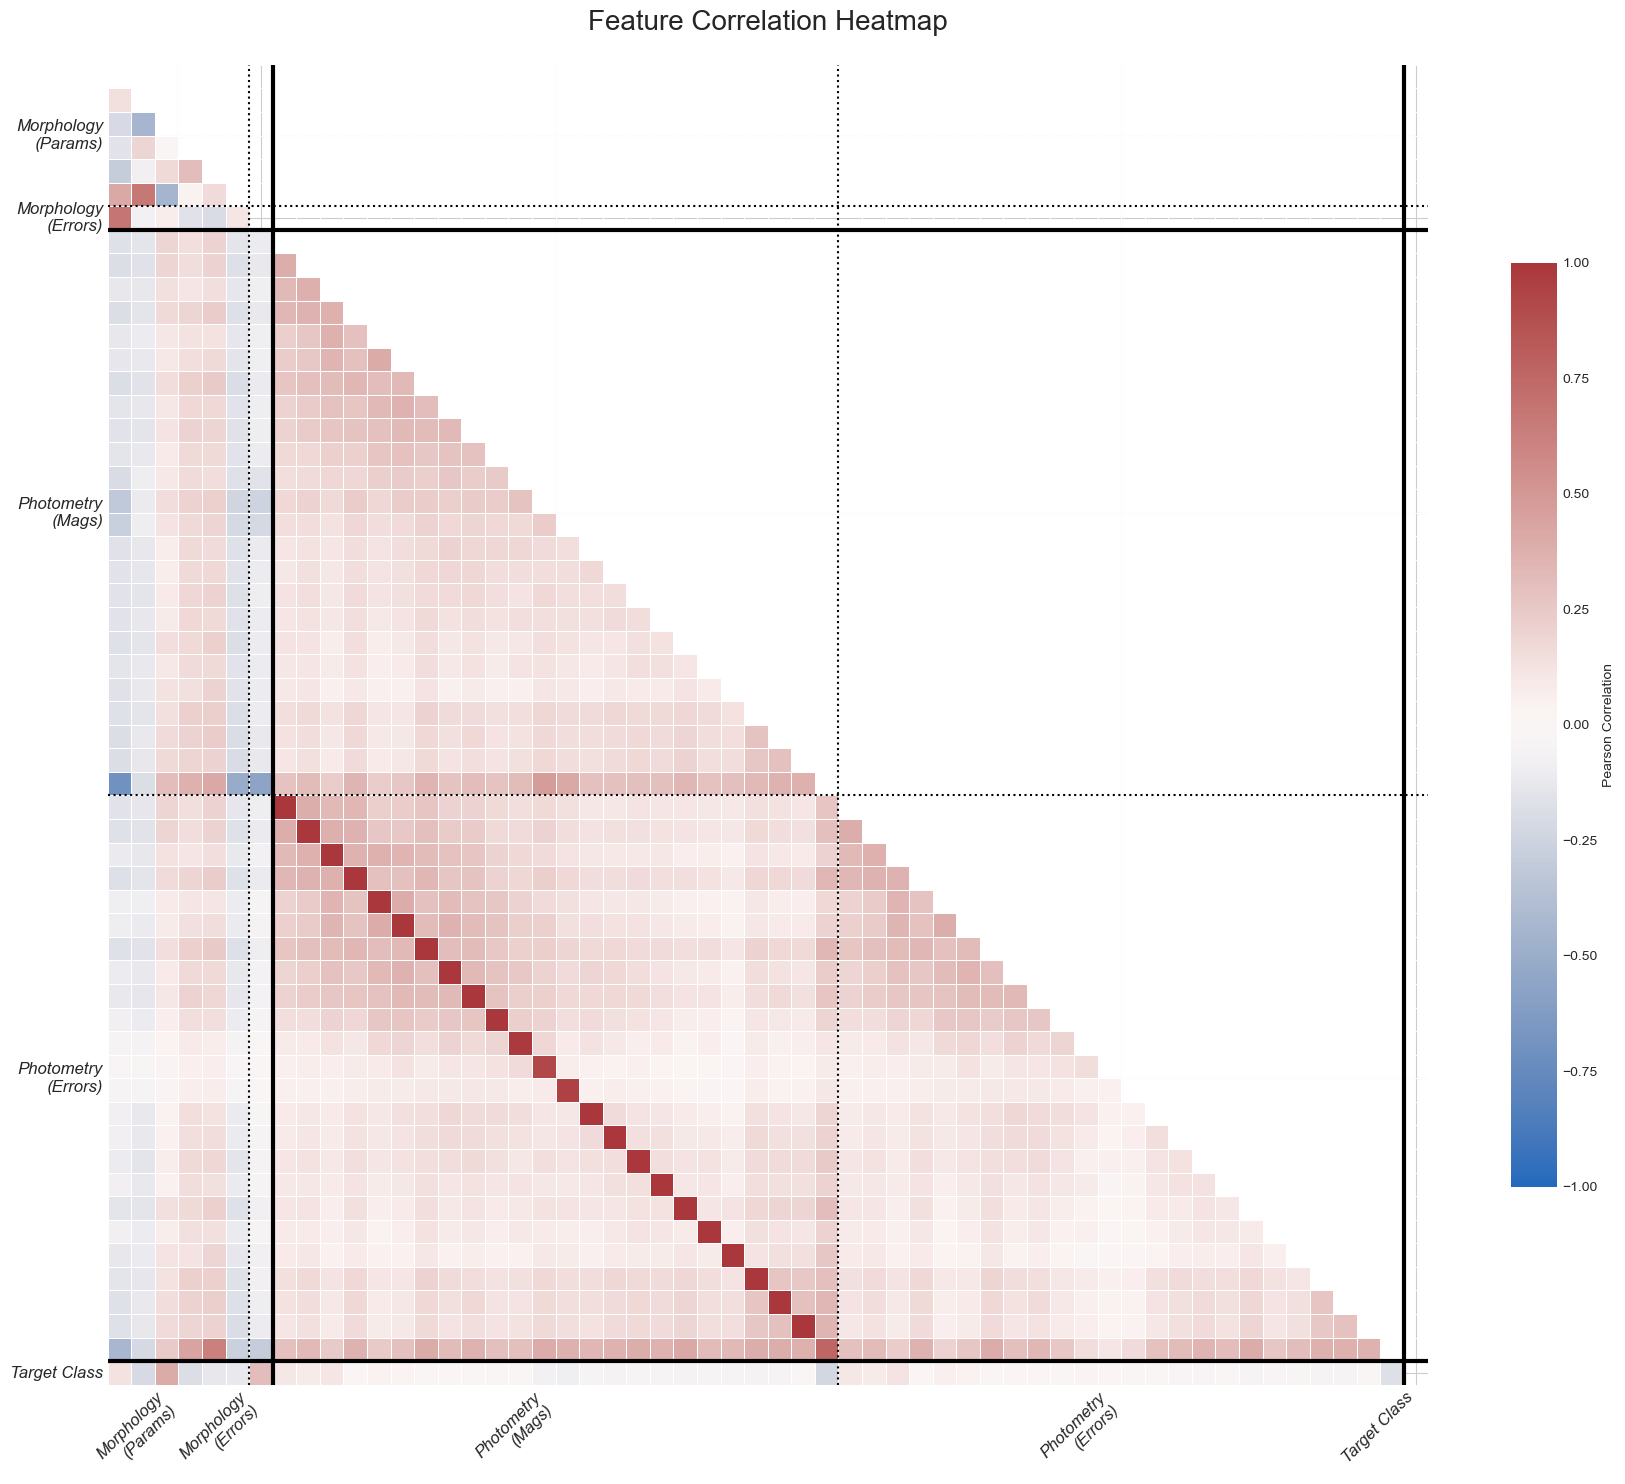

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Section 1: Setup and Helper Functions (to make the cell standalone) ---

# B. Feature Definitions (from original notebook cell [5])
# This section defines the lists of column names we need.
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
photometry_magnitudes = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W', 'F613W', 'F644W', 
    'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W',
    'J', 'H', 'KS', 'F814W'
]
photometry_uncertainties = [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W', 'dF613W', 'dF644W', 
    'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W',
    'dJ', 'dH', 'dKS', 'dF814W'
]
target_variable = ['acs_mu_class']

# C. Group Definitions (from original notebook cell [5])
# This defines the 'group_3' we want to analyze.
groups = {
    'group_1': morphology_features + morphology_err + target_variable,
    'group_2': photometry_magnitudes + photometry_uncertainties + target_variable,
    'group_3': morphology_features + morphology_err + photometry_magnitudes + photometry_uncertainties + target_variable
}

# D. Helper Functions (get_feature_set and clean_data from original notebook cell [7])
def get_feature_set(df, set_name, groups=groups):
    """Selects columns from a DataFrame based on a predefined feature set name."""
    if set_name not in groups:
        raise ValueError(f"Feature set group '{set_name}' not defined.")
    required_cols = groups[set_name]
    available_cols = [col for col in required_cols if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    """Cleans the input DataFrame by selecting features, dropping NaNs, and separating X and y."""
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    if target_column not in df_clean.columns:
        raise KeyError(f"Target column '{target_column}' not found in the cleaned DataFrame.")
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y, df_clean


# --- Section 2: Main Correlation and Plotting Logic ---

# A. Data Loading and Preprocessing (from original notebook cell [4])
try:
    df_original = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    # Drop fake detections and map classes to 0 (Galaxy) and 1 (Star)
    df = df_original[df_original['acs_mu_class'] != 3].copy()
    df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})
    print("Successfully loaded and preprocessed the dataset.")
except FileNotFoundError:
    print("Error: Data file not found. Please ensure 'data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv' is accessible.")
    # Create a dummy dataframe to allow the rest of the script to run for demonstration
    all_cols_for_dummy = morphology_features + morphology_err + photometry_magnitudes + photometry_uncertainties + target_variable
    df = pd.DataFrame(np.random.rand(100, len(all_cols_for_dummy)), columns=all_cols_for_dummy)
    df['acs_mu_class'] = np.random.randint(0, 2, 100)
    print("Proceeding with a dummy dataframe for demonstration.")


# B. Prepare Data and Feature Order for the Plot
# Define the specific order of features for the plot
g1_mag_cols = morphology_features
g1_err_cols = morphology_err
g2_mag_cols = photometry_magnitudes
g2_err_cols = photometry_uncertainties
target_col = target_variable

# Create the final ordered list of columns
ordered_cols = g1_mag_cols + g1_err_cols + g2_mag_cols + g2_err_cols + target_col

# Use the clean_data function to get the data for group 3 and drop NaNs
_, _, df_group3_clean = clean_data(df, 'group_3', target_variable[0])

# Reorder the cleaned DataFrame columns according to our specified list
df_ordered = df_group3_clean[ordered_cols]
print(f"Prepared data for Group 3 with {df_ordered.shape[1]} features in the specified order.")

# C. Compute Correlation and Create Mask
corr_matrix = df_ordered.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# D. Plotting the Heatmap
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr_matrix, 
            mask=mask, 
            cmap='vlag',
            vmax=1.0, 
            vmin=-1.0,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .7, "label": "Pearson Correlation"},
            ax=ax)

# E. Add Separator Lines and Section Labels
section_labels = [
    'Morphology\n(Params)', 
    'Morphology\n(Errors)', 
    'Photometry\n(Mags)', 
    'Photometry\n(Errors)', 
    'Target Class'
]
section_sizes = [len(g1_mag_cols), len(g1_err_cols), len(g2_mag_cols), len(g2_err_cols), len(target_col)]
cumulative_sizes = np.cumsum(section_sizes)
line_positions = cumulative_sizes[:-1]

# Draw horizontal and vertical separator lines
for i, pos in enumerate(line_positions):
    # Dotted line between parameters and errors within a group
    is_internal_divider = (i == 0) or (i == 2)
    linestyle = ':' if is_internal_divider else '-'
    linewidth = 1.5 if is_internal_divider else 3.0
    
    ax.axhline(y=pos, color='black', linestyle=linestyle, linewidth=linewidth)
    ax.axvline(x=pos, color='black', linestyle=linestyle, linewidth=linewidth)

# Calculate positions for section labels (in the middle of each section)
label_positions = [0] + list(cumulative_sizes)
tick_positions = [(label_positions[i] + label_positions[i+1]) / 2 for i in range(len(label_positions)-1)]

# Set custom ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(section_labels, rotation=45, ha='right', fontsize=12, style='italic')
ax.set_yticks(tick_positions)
ax.set_yticklabels(section_labels, rotation=0, va='center', fontsize=12, style='italic')

# F. Final Touches
ax.tick_params(axis='both', which='major', length=0) # Hide tick marks for a cleaner look
ax.set_title('Feature Correlation Heatmap', fontsize=20, pad=25)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [28]:
# ===================================================================
#               Standalone Debugging Cell for LightGBM
# ===================================================================
# Purpose: To diagnose why LightGBM collapses on the 'group_1' feature
# set and to test potential solutions.

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Essential Functions and Data from Original Notebook ---

# A. Feature Definitions
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
target_variable = ['acs_mu_class']

# B. Group Definition for 'group_1'
groups = {
    'group_1': morphology_features + morphology_err + target_variable,
}

# C. Helper Functions for Data Prep
def get_feature_set(df, set_name, groups=groups):
    if set_name not in groups:
        raise ValueError(f"Feature set group '{set_name}' not defined.")
    return df[groups[set_name]]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y, df_clean

# --- 3. Data Loading and Preparation ---
print("--- Preparing Data for Group 1 ---")
try:
    df_original = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    df = df_original[df_original['acs_mu_class'] != 3].copy()
    df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})

    # Prepare data specifically for group_1
    X, y, _ = clean_data(df, 'group_1', target_variable[0])

    # Create a simple Train/Validation split for debugging early stopping
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"Data prepared successfully. Train shape: {X_train.shape}, Val shape: {X_val.shape}")
    print(f"Class imbalance weight (scale_pos_weight): {scale_pos_weight:.2f}")
    print("-" * 50 + "\n")

except FileNotFoundError:
    print("FATAL ERROR: Data file not found. Cannot proceed with debugging.")
    # Stop execution if data is not available
    X_train = None


# --- 4. Diagnostic Experiments ---
if X_train is not None:

    # EXPERIMENT 1: Replicate the Collapse with 'logloss'
    # ---------------------------------------------------
    print(">>> EXPERIMENT 1: Replicating the collapse using 'logloss' for early stopping.")
    model_exp1 = lgb.LGBMClassifier(
        objective='binary',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        verbose=-1
    )
    model_exp1.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='logloss', # The problematic metric
        callbacks=[lgb.early_stopping(10, verbose=False)]
    )
    print(f"Result: Model stopped at iteration {model_exp1.best_iteration_}")
    y_pred_exp1 = model_exp1.predict(X_val)
    print("Classification Report (Experiment 1):")
    print(classification_report(y_val, y_pred_exp1, zero_division=0))
    print("-" * 50 + "\n")


    # EXPERIMENT 2: Fix Early Stopping with 'auc'
    # ---------------------------------------------
    # HYPOTHESIS: Using a metric sensitive to the minority class (like roc_auc)
    # for early stopping will prevent the collapse.
    print(">>> EXPERIMENT 2: Using 'auc' as the metric for early stopping.")
    model_exp2 = lgb.LGBMClassifier(
        objective='binary',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_estimators=500, # Give it plenty of room to train
        verbose=-1
    )
    model_exp2.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc', # The CORRECT metric for this problem
        callbacks=[lgb.early_stopping(50, verbose=False)] # Use more patience
    )
    print(f"Result: Model stopped at iteration {model_exp2.best_iteration_}")
    y_pred_exp2 = model_exp2.predict(X_val)
    print("Classification Report (Experiment 2):")
    print(classification_report(y_val, y_pred_exp2, zero_division=0))
    print("-" * 50 + "\n")


    # EXPERIMENT 3: Check Feature Importances
    # ----------------------------------------
    # HYPOTHESIS: The features in group_1 might be very weak, making the model's job hard.
    # Let's see what the (hopefully now working) model from Exp 2 learned.
    print(">>> EXPERIMENT 3: Checking feature importances from the model in Exp 2.")
    if model_exp2.best_iteration_ > 2: # Only if the model trained meaningfully
        lgb.plot_importance(model_exp2, figsize=(10, 6), title="Feature Importances (Group 1)")
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping feature importance plot because the model did not train.")
    print("-" * 50 + "\n")


    # EXPERIMENT 4: Simple Random Search with F1-Score
    # -------------------------------------------------
    # HYPOTHESIS: Maybe a different set of hyperparameters can work better.
    # We will use RandomizedSearchCV with 'f1' as the scoring metric.
    print(">>> EXPERIMENT 4: Running a quick RandomizedSearchCV focused on F1 score.")
    param_dist = {
        'num_leaves': randint(10, 50),
        'learning_rate': uniform(0.01, 0.2),
        'min_child_samples': randint(5, 40),
        'subsample': uniform(0.6, 0.4), # range is [loc, loc+scale]
        'colsample_bytree': uniform(0.6, 0.4)
    }

    # Create a base estimator
    lgbm = lgb.LGBMClassifier(
        objective='binary',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_estimators=100, # Fixed number of estimators for the search
        verbose=-1
    )

    # Setup the search with F1 scoring
    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_dist,
        n_iter=15, # Number of parameter settings that are sampled
        scoring='f1_weighted', # Focus on a balanced F1 score
        cv=3, # 3-fold cross-validation
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Run the search on the training data
    random_search.fit(X_train, y_train)

    print("\nBest parameters found by RandomizedSearch:")
    print(random_search.best_params_)
    print(f"Best F1 score during search: {random_search.best_score_:.4f}")

    # Evaluate the best model from the search on the validation set
    best_model_rs = random_search.best_estimator_
    y_pred_rs = best_model_rs.predict(X_val)
    print("\nClassification Report (from RandomizedSearch best model):")
    print(classification_report(y_val, y_pred_rs, zero_division=0))
    print("-" * 50 + "\n")

--- Preparing Data for Group 1 ---
Data prepared successfully. Train shape: (21910, 7), Val shape: (5478, 7)
Class imbalance weight (scale_pos_weight): 13.22
--------------------------------------------------

>>> EXPERIMENT 1: Replicating the collapse using 'logloss' for early stopping.
Result: Model stopped at iteration 2
Classification Report (Experiment 1):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5093
           1       0.00      0.00      0.00       385

    accuracy                           0.93      5478
   macro avg       0.46      0.50      0.48      5478
weighted avg       0.86      0.93      0.90      5478

--------------------------------------------------

>>> EXPERIMENT 2: Using 'auc' as the metric for early stopping.
Result: Model stopped at iteration 2
Classification Report (Experiment 2):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5093
         

In [29]:
# ===================================================================
#         Targeted Debugging Cell: Fixing Early Stopping
# ===================================================================
# Purpose: To prove that hyperparameters are the reason early stopping
# is failing, even with the 'auc' metric.

# --- 1. Imports and Setup (Identical to previous cell) ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# --- 2. Essential Functions and Data (Identical to previous cell) ---
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
target_variable = ['acs_mu_class']
groups = {'group_1': morphology_features + morphology_err + target_variable}

def get_feature_set(df, set_name, groups=groups):
    return df[groups[set_name]]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y, df_clean

# --- 3. Data Loading and Preparation (Identical to previous cell) ---
print("--- Preparing Data for Group 1 ---")
try:
    df_original = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    df = df_original[df_original['acs_mu_class'] != 3].copy()
    df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})
    X, y, _ = clean_data(df, 'group_1', target_variable[0])
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"Data prepared. scale_pos_weight: {scale_pos_weight:.2f}\n")
    X_train_exists = True
except FileNotFoundError:
    print("FATAL ERROR: Data file not found.")
    X_train_exists = False

# --- 4. NEW Diagnostic Experiments ---
if X_train_exists:

    # EXPERIMENT A: The "Proof"
    # -----------------------------------------------------------------
    # HYPOTHESIS: If we use the successful parameters from your RandomizedSearch,
    # then early stopping with 'auc' WILL work.
    print(">>> EXPERIMENT A: Using successful HPs from your previous run with early stopping.")

    # These are the parameters your successful search found
    successful_params = {
        'objective': 'binary',
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'n_estimators': 1000, # Give it lots of room
        'colsample_bytree': 0.6362,
        'learning_rate': 0.1336,
        'min_child_samples': 7,
        'num_leaves': 46,
        'subsample': 0.8430,
        'verbose': -1
    }

    model_expA = lgb.LGBMClassifier(**successful_params)
    model_expA.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50, verbose=True)] # Verbose to see the AUC scores
    )

    print(f"\nResult: Model stopped at iteration {model_expA.best_iteration_}")
    y_pred_expA = model_expA.predict(X_val)
    print("Classification Report (Experiment A):")
    print(classification_report(y_val, y_pred_expA, zero_division=0))
    print("-" * 50 + "\n")


    # EXPERIMENT B: Why it works - A more "aggressive" learning rate
    # -----------------------------------------------------------------
    # HYPOTHESIS: A higher learning rate can help the model find a signal faster.
    # The default is 0.1. Your successful model used 0.13. Let's try 0.05.
    print(">>> EXPERIMENT B: Testing if a more aggressive learning_rate helps.")

    aggressive_params = {
        'objective': 'binary',
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'n_estimators': 1000,
        'learning_rate': 0.05, # Higher than default 0.1, but maybe more stable
        'verbose': -1
        # Using other defaults (like num_leaves=31)
    }

    model_expB = lgb.LGBMClassifier(**aggressive_params)
    model_expB.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    print(f"Result: Model stopped at iteration {model_expB.best_iteration_}")
    y_pred_expB = model_expB.predict(X_val)
    print("Classification Report (Experiment B):")
    print(classification_report(y_val, y_pred_expB, zero_division=0))
    print("-" * 50 + "\n")


    # EXPERIMENT C: Boosting the feature power
    # -----------------------------------------------------------------
    # HYPOTHESIS: The model needs more features to work reliably. Let's add
    # just a few photometric features to group_1 and see the difference.
    print(">>> EXPERIMENT C: Testing with a slightly enriched feature set.")

    try:
        # Create a new "group_1_plus"
        enriched_features = morphology_features + morphology_err + ['F814W', 'dF814W', 'J', 'dJ'] + target_variable
        groups['group_1_plus'] = enriched_features

        X_e, y_e, _ = clean_data(df, 'group_1_plus', target_variable[0])
        X_train_e, X_val_e, y_train_e, y_val_e = train_test_split(
            X_e, y_e, test_size=0.2, random_state=42, stratify=y_e
        )

        # Train with default parameters again, but on the better data
        model_expC = lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight, random_state=42, verbose=-1)
        model_expC.fit(
            X_train_e, y_train_e,
            eval_set=[(X_val_e, y_val_e)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )

        print(f"Result: Model with enriched features stopped at iteration {model_expC.best_iteration_}")
        y_pred_expC = model_expC.predict(X_val_e)
        print("Classification Report (Experiment C - Enriched Features):")
        print(classification_report(y_val_e, y_pred_expC, zero_division=0))
        print("-" * 50 + "\n")

    except KeyError as e:
        print(f"Skipping Experiment C because a required feature was not found: {e}")

--- Preparing Data for Group 1 ---
Data prepared. scale_pos_weight: 13.22

>>> EXPERIMENT A: Using successful HPs from your previous run with early stopping.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.846898	valid_0's binary_logloss: 0.216996

Result: Model stopped at iteration 1
Classification Report (Experiment A):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5093
           1       0.00      0.00      0.00       385

    accuracy                           0.93      5478
   macro avg       0.46      0.50      0.48      5478
weighted avg       0.86      0.93      0.90      5478

--------------------------------------------------

>>> EXPERIMENT B: Testing if a more aggressive learning_rate helps.
Result: Model stopped at iteration 5
Classification Report (Experiment B):
              precision    recall  f1-score   support

           0       0.93      1

Added directory to Python's path: c:\Users\javym\Documents\Github\TFGs\Fisica\ML-for-star-galaxy-classification
Successfully imported RawVennAbers and CVAPPredictorRaw.

--- Preparing Data for Group 1 ---
Data prepared successfully.

--- Calibrating the base model with CVAP ---


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fit

CVAP calibration complete.

>>> VISUALIZING THE CALIBRATED PROBABILITIES <<<



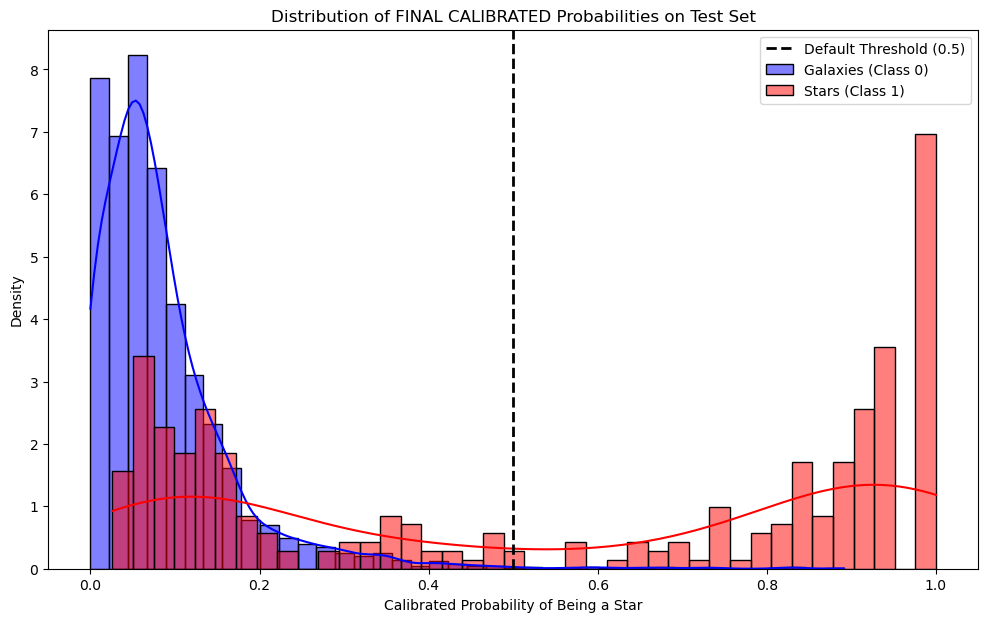


Optimal decision threshold on calibrated probabilities: 0.4852

--- Final Results Comparison ---

Classification Report (using default 0.5 threshold on calibrated probabilities):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3820
           1       0.89      0.53      0.66       289

    accuracy                           0.96      4109
   macro avg       0.93      0.76      0.82      4109
weighted avg       0.96      0.96      0.96      4109


Classification Report (using OPTIMAL threshold on calibrated probabilities):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3820
           1       0.89      0.54      0.67       289

    accuracy                           0.96      4109
   macro avg       0.93      0.77      0.83      4109
weighted avg       0.96      0.96      0.96      4109



In [4]:
# ===================================================================
#      Final Debugging Cell: Fixing the Import & the Threshold
# ===================================================================
# Purpose: To correctly import the CVAP module and prove that even
#          after proper calibration, an optimal decision threshold is
#          required for imbalanced classification.

# --- 1. Fix the Python Path to Allow Import ---
import sys
import os

# Get the current working directory of the notebook
# This assumes 'raw_cvap.py' is in the same folder as your notebook.
notebook_dir = os.getcwd()

# Add this directory to Python's path if it's not already there
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)
    print(f"Added directory to Python's path: {notebook_dir}")
else:
    print(f"Directory is already in Python's path: {notebook_dir}")

# --- 2. Import the CVAP Classes (Now it should work) ---
try:
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
    print("Successfully imported RawVennAbers and CVAPPredictorRaw.")
    cvap_imported = True
except ImportError as e:
    print("\n--- IMPORT FAILED ---")
    print(f"Error: {e}")
    print("Please make sure the file 'raw_cvap.py' is in the same directory as this notebook.")
    print(f"Current Notebook Directory: {os.getcwd()}")
    cvap_imported = False

# --- 3. Standard Library Imports for the Experiment ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns


# --- 4. Essential Functions and Data ---
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
target_variable = ['acs_mu_class']
groups = {'group_1': morphology_features + morphology_err + target_variable}

def get_feature_set(df, set_name, groups=groups):
    return df[groups[set_name]]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y, df_clean

# --- 5. Data Loading and Preparation ---
print("\n--- Preparing Data for Group 1 ---")
try:
    df_original = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    df = df_original[df_original['acs_mu_class'] != 3].copy()
    df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})
    X, y, _ = clean_data(df, 'group_1', target_variable[0])

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    print("Data prepared successfully.")
    data_loaded = True
except FileNotFoundError:
    print("FATAL ERROR: Data file not found.")
    data_loaded = False

# --- 6. The Definitive Experiment (runs only if import and data are ready) ---
if data_loaded and cvap_imported:
    # A. Define our best LightGBM model
    best_hps = {
        'objective': 'binary', 'random_state': 42,
        'colsample_bytree': 0.6362, 'learning_rate': 0.1336,
        'min_child_samples': 7, 'num_leaves': 46, 'subsample': 0.8430,
        'n_estimators': 150, 'verbose': -1,
        'scale_pos_weight': (y_train_full == 0).sum() / (y_train_full == 1).sum()
    }
    base_estimator = lgb.LGBMClassifier(**best_hps)

    # B. Calibrate the model with CVAP, exactly like your workflow
    print("\n--- Calibrating the base model with CVAP ---")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_scores_list, oof_y_cal_list = [], []

    X_train_np = X_train_full.values
    y_train_np = y_train_full.values

    # Using predict_proba based on your successful RandomizedSearch setup
    for train_idx, val_idx in cv.split(X_train_np, y_train_np):
        est = clone(base_estimator).fit(X_train_np[train_idx], y_train_np[train_idx])
        scores = est.predict_proba(X_train_np[val_idx])[:, 1]
        oof_scores_list.append(scores)
        oof_y_cal_list.append(y_train_np[val_idx])

    final_base_estimator = clone(base_estimator).fit(X_train_np, y_train_np)
    calibrators = [RawVennAbers().fit(s, y) for s, y in zip(oof_scores_list, oof_y_cal_list)]

    cvap_predictor = CVAPPredictorRaw(
        final_estimator_=final_base_estimator,
        calibrators_=calibrators,
        loss_='log',
        score_method_='predict_proba' # Must match how scores were generated
    )
    print("CVAP calibration complete.")

    # C. Get CALIBRATED probabilities on the hold-out test set
    calibrated_proba_test = cvap_predictor.predict_proba(X_test)[:, 1]

    # D. Visualize the calibrated probabilities
    print("\n>>> VISUALIZING THE CALIBRATED PROBABILITIES <<<\n")
    plt.figure(figsize=(12, 7))
    sns.histplot(calibrated_proba_test[y_test == 0], color='blue', label='Galaxies (Class 0)', stat='density', common_norm=False, bins=40, kde=True)
    sns.histplot(calibrated_proba_test[y_test == 1], color='red', label='Stars (Class 1)', stat='density', common_norm=False, bins=40, kde=True)
    plt.axvline(0.5, color='black', linestyle='--', lw=2, label='Default Threshold (0.5)')
    plt.title('Distribution of FINAL CALIBRATED Probabilities on Test Set')
    plt.xlabel('Calibrated Probability of Being a Star')
    plt.legend()
    plt.show()

    # E. Find the optimal threshold on these CALIBRATED probabilities
    precision, recall, thresholds = precision_recall_curve(y_test, calibrated_proba_test)
    f1_scores = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(precision), where=(precision + recall) != 0)
    optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]

    print(f"\nOptimal decision threshold on calibrated probabilities: {optimal_threshold:.4f}\n")

    # F. Compare the classification reports
    print("--- Final Results Comparison ---\n")
    print("Classification Report (using default 0.5 threshold on calibrated probabilities):")
    y_pred_default = (calibrated_proba_test >= 0.5).astype(int)
    print(classification_report(y_pred=y_pred_default, y_true=y_test, zero_division=0))

    print("\nClassification Report (using OPTIMAL threshold on calibrated probabilities):")
    y_pred_optimal = (calibrated_proba_test >= optimal_threshold).astype(int)
    print(classification_report(y_pred=y_pred_optimal, y_true=y_test, zero_division=0))

In [5]:
# ===================================================================
#                      Workflow Audit Cell
# ===================================================================
# Purpose: To inspect the exact hyperparameters being used by the
#          workflow for group_1 and compare them to a known-good set.

import json
import os

print("--- Auditing Workflow Parameters for group_1 ---")

# --- 1. Define the "Known-Good" Parameters ---
# These are the parameters that worked in our successful debug experiments.
known_good_params = {
    'objective': 'binary',
    'random_state': 42,
    'colsample_bytree': 0.6362,
    'learning_rate': 0.1336,
    'min_child_samples': 7,
    'num_leaves': 46,
    'subsample': 0.8430,
    'n_estimators': 150,
    'verbose': -1
    # Note: scale_pos_weight is calculated dynamically.
}
print("1. KNOWN-GOOD PARAMETERS (for comparison):")
print(json.dumps(known_good_params, indent=4))


# --- 2. Mimic the Workflow's Parameter Loading ---
# This code is copied from the start of your main workflow loop (In[25])
BEST_PARAMS_DIR = "best_params"
group_name_to_audit = 'group_1'
model_name_to_audit = 'LightGBM' # The key used in your JSON file

params_filepath = os.path.join(BEST_PARAMS_DIR, f"{group_name_to_audit}_best_params.json")
loaded_params_from_file = {}

if os.path.exists(params_filepath):
    try:
        with open(params_filepath, 'r') as f:
            all_params_for_group = json.load(f)
            loaded_params_from_file = all_params_for_group.get(model_name_to_audit)
        print("\n2. PARAMETERS LOADED FROM JSON FILE:")
        if loaded_params_from_file:
            print(json.dumps(loaded_params_from_file, indent=4))
        else:
            print(f"'{model_name_to_audit}' key not found in {params_filepath}")
            
    except Exception as e:
        print(f"\nERROR loading or parsing {params_filepath}: {e}")
else:
    print(f"\nERROR: Parameters file not found at {params_filepath}")


# --- 3. Manual Comparison ---
print("\n--- ACTION REQUIRED ---")
print("Compare the 'KNOWN-GOOD PARAMETERS' (1) with the 'PARAMETERS LOADED FROM JSON' (2).")
print("Are they identical? If not, the HPO process saved different parameters than the ones that worked.")
print("If they are identical, the problem lies in how these parameters are being passed or modified *inside* the lgbm_workflow function.")

--- Auditing Workflow Parameters for group_1 ---
1. KNOWN-GOOD PARAMETERS (for comparison):
{
    "objective": "binary",
    "random_state": 42,
    "colsample_bytree": 0.6362,
    "learning_rate": 0.1336,
    "min_child_samples": 7,
    "num_leaves": 46,
    "subsample": 0.843,
    "n_estimators": 150,
    "verbose": -1
}

2. PARAMETERS LOADED FROM JSON FILE:
{
    "colsample_bytree": 0.9252309722947032,
    "learning_rate": 0.10579748529279263,
    "max_depth": 10,
    "metric": "logloss",
    "min_child_samples": 17,
    "num_leaves": 27,
    "objective": "binary",
    "reg_alpha": 0.00024991242947225575,
    "reg_lambda": 0.02544659616528781,
    "subsample": 0.5818175813025477,
    "verbose": -1,
    "random_state": 33,
    "scale_pos_weight": 13.22181008902077
}

--- ACTION REQUIRED ---
Compare the 'KNOWN-GOOD PARAMETERS' (1) with the 'PARAMETERS LOADED FROM JSON' (2).
Are they identical? If not, the HPO process saved different parameters than the ones that worked.
If they are id